<a href="https://colab.research.google.com/github/ShotaSasaki-HU/ASTRO-CAMP-2025/blob/main/sarimax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ライブラリ

In [172]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import datetime as dt
import ee
from tqdm import tqdm # 進捗表示用
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
!pip install japanize-matplotlib
import japanize_matplotlib
import itertools
import pytz
from sklearn.metrics import mean_squared_error
import seaborn as sns
from pathlib import Path
!pip install rasterio
import rasterio
from rasterio.warp import reproject, Resampling
from scipy.signal import savgol_filter


# Google Driveのマウント

In [173]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# データ準備

## 目的変数（誘殺数）

### 5年間の時系列化

In [174]:
all_years = []

for year in range(2020, 2024 + 1):
    # セジロウンカ
    path = (
        "https://github.com/ShotaSasaki-HU/ASTRO-CAMP-2025/raw/refs/heads/"
        "main/data/%E9%A6%99%E5%B7%9D%E7%9C%8C%E8%BE%B2%E6%A5%AD%E8%A9%A6%"
        "E9%A8%93%E5%A0%B4%E7%97%85%E5%AE%B3%E8%99%AB%E9%98%B2%E9%99%A4%E6"
        "%89%80_%E6%A5%AD%E5%8B%99%E5%B9%B4%E5%A0%B1_%E5%90%84%E3%82%A4%E3"
        "%83%8D%E3%82%A6%E3%83%B3%E3%82%AB%E9%A1%9E%E3%81%AE%E6%97%A5%E5%8"
        "8%A5%E8%AA%98%E6%AE%BA%E6%95%B0/%E3%82%BB%E3%82%B8%E3%83%AD%E3%82"
        "%A6%E3%83%B3%E3%82%AB%E6%97%A5%E5%88%A5%E8%AA%98%E6%AE%BA%E6%95%B"
        f"0_{year}.csv"
    )
    df_year = pd.read_csv(path, encoding="utf-8", header=0, index_col=0)

    # 「欠測」を0と見做す
    df_year.replace('欠測', 0, inplace=True)

    # メスとオスの和
    for month in range(4, 11 + 1):
        df_year[f'{month}月'] = df_year[f'{month}月_メス'].astype('float64') + df_year[f'{month}月_オス'].astype('float64') # NaNを扱うためにfloat
        df_year.drop([f'{month}月_メス', f'{month}月_オス'], axis=1, inplace=True)

    # 縦持ちへ変換
    df_year = df_year.melt(
        id_vars=['日'], # そのまま残る列
        value_vars=['4月', '5月', '6月', '7月', '8月', '9月', '10月', '11月'], # 値となる列
        var_name='月', # 新しい列名
        value_name='kill_score'
        )

    # 「西向く侍」のNaN値を排除
    df_year.dropna(inplace=True)

    # '月'を数値化
    df_year['月'] = df_year['月'].str.replace('月', '').astype(int)

    # datetime生成
    df_year['date'] = pd.to_datetime({
        'year': year,
        'month': df_year['月'],
        'day': df_year['日'].astype(int)
    }, errors='raise')
    df_year = df_year.sort_values('date').reset_index(drop=True) # 時系列順にソート

    df_year = df_year[['date', 'kill_score']]
    all_years.append(df_year)

# 5年分を結合
df_resp = pd.concat(all_years, ignore_index=True)
df_resp['kill_score'] = df_resp['kill_score'].astype(int)

print(df_resp)


           date  kill_score
0    2020-04-01           0
1    2020-04-02           0
2    2020-04-03           0
3    2020-04-04           0
4    2020-04-05           0
...         ...         ...
1215 2024-11-26           0
1216 2024-11-27           0
1217 2024-11-28           0
1218 2024-11-29           0
1219 2024-11-30           0

[1220 rows x 2 columns]


### 月半旬（5日ごと）でグループ化
pandas.DataFrame.resampleを使う手もある．

In [175]:
df_resp['year'] = df_resp['date'].dt.year
df_resp['month'] = df_resp['date'].dt.month
df_resp['day'] = df_resp['date'].dt.day

df_resp['hanjun'] = pd.cut(
    df_resp['day'],
    bins=[0, 5, 10, 15, 20, 25, 31], # 区切り
    labels=[1, 6, 11, 16, 21, 26]    # 月半旬開始日
)

df_resp['hanjun_start'] = pd.to_datetime({
    'year': df_resp['year'],
    'month': df_resp['month'],
    'day': df_resp['hanjun']
}, errors='raise')
df_resp = df_resp.sort_values('hanjun_start').reset_index(drop=True) # 時系列順にソート

df_resp = df_resp.groupby(['hanjun_start'], as_index=False)['kill_score'].sum()

print(df_resp)


    hanjun_start  kill_score
0     2020-04-01           0
1     2020-04-06           0
2     2020-04-11           0
3     2020-04-16           0
4     2020-04-21           0
..           ...         ...
235   2024-11-06           0
236   2024-11-11           0
237   2024-11-16           0
238   2024-11-21           0
239   2024-11-26           0

[240 rows x 2 columns]


### 冬の誘殺数を0埋めで生成（1月〜3月，12月）

In [176]:
# 1. 2020〜2024年の全ての「月半旬」の日付リストを生成
full_hanjun_dates = []
for year in range(2020, 2025):
    for month in range(1, 13): # 1月〜12月
        for day in [1, 6, 11, 16, 21, 26]:
            full_hanjun_dates.append(pd.Timestamp(year=year, month=month, day=day))

# 2. 全ての日付を持つ「テンプレート」データフレームを作成
df_template = pd.DataFrame({'hanjun_start': full_hanjun_dates})

# 3. テンプレートに元のデータを結合（'left' join）
#   -> テンプレートの日付は全て残り、元のデータにない期間（冬）はNaNになる．
df_resp = pd.merge(df_template, df_resp, on='hanjun_start', how='left')

# 4. 全てのNaN値を0で埋める．
df_resp = df_resp.fillna(0)

df_resp['kill_score'] = df_resp['kill_score'].astype(int)
print(df_resp)


    hanjun_start  kill_score
0     2020-01-01           0
1     2020-01-06           0
2     2020-01-11           0
3     2020-01-16           0
4     2020-01-21           0
..           ...         ...
355   2024-12-06           0
356   2024-12-11           0
357   2024-12-16           0
358   2024-12-21           0
359   2024-12-26           0

[360 rows x 2 columns]


### 誘殺数の原系列を可視化

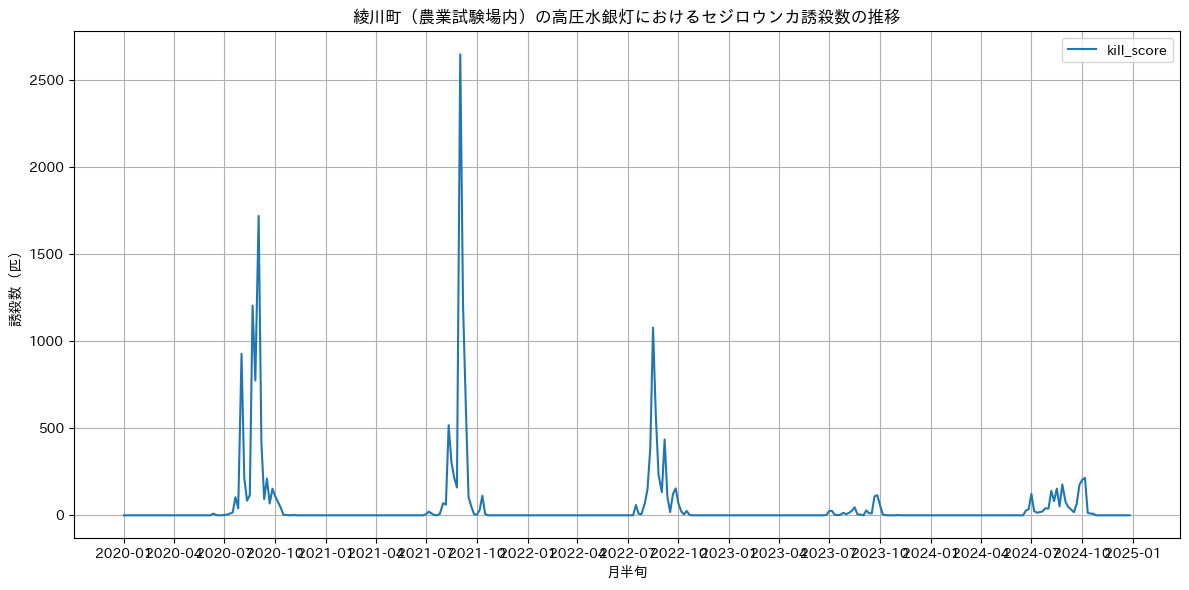

In [177]:
plt.figure(figsize=(12,6))
plt.plot(df_resp["hanjun_start"], df_resp["kill_score"], label="kill_score")

# 月ごとに目盛りを表示
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m")) # YYYY-MM 表記

plt.title("綾川町（農業試験場内）の高圧水銀灯におけるセジロウンカ誘殺数の推移")
plt.xlabel("月半旬")
plt.ylabel("誘殺数（匹）")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 説明変数

### Google Earth Engineの認証

In [178]:
ee.Authenticate() # Colabではブラウザで認証を行う
ee.Initialize(project='astro-camp')
# ee.Initialize(project='my-project-astrocamp')


### １．積算温度（福建省）

#### CSV生成
CSVを作成済みの場合は，このセルをスキップする．

In [179]:
"""
aoi = ee.Geometry.Rectangle([118.64617, 25.00743, 118.76769, 25.10490])
developmental_zero = 12.0 # 発育下限温度（発育零点）
PERIOD_DAYS = 5

# 指定された期間の積算温度を計算する関数
def get_degree_days_for_period(start_date, end_date):
    ee_start_date = ee.Date(start_date.strftime('%Y-%m-%d'))
    ee_end_date = ee.Date(end_date.strftime('%Y-%m-%d'))
    days_in_period = ee_end_date.difference(ee_start_date, 'day')

    # 指定した月半旬のMODIS画像コレクションを取得
    collection = ee.ImageCollection('MODIS/061/MOD11A1').filterDate(ee_start_date, ee_end_date)

    # --- ここからが積算温度の計算部分 ---

    # 期間内の画像枚数をサーバーサイドでカウント
    image_count = collection.size()

    # 画像が1枚以上ある場合の関数
    def calculate_stats(img_collection):
        # 日々の積算温度を計算する関数
        def calculate_degree_days(image):
            # LSTバンドを選択し，スケール変換と単位変換（ケルビン -> 摂氏）．
            temp_celsius = image.select('LST_Day_1km').multiply(0.02).subtract(273.15)
            # (気温 - 基準温度) を計算．結果がマイナスなら0にする．
            degree_day = temp_celsius.subtract(developmental_zero).max(0)
            return degree_day

        # コレクション内の各画像（各日）に対して上記の関数を適用
        daily_degree_days = collection.map(calculate_degree_days)

        # 期間内の日平均積算温度を計算し、期間の日数を掛けて正規化
        total_degree_days_image = daily_degree_days.mean().multiply(days_in_period).rename('Degree_Days')

        # AOI内の平均値を計算
        stats = total_degree_days_image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=aoi,
            scale=1000,
            maxPixels=1e9
        )
        return stats

    # 画像が0枚だった場合の関数
    def empty_case():
        return ee.Dictionary({'Degree_Days': None})

    # image_count > 0 の条件で分岐を実行
    # ee.Algorithms.If(condition, true_case, false_case)
    # greater than(0)
    stats = ee.Dictionary(ee.Algorithms.If(image_count.gt(0), calculate_stats(collection), empty_case()))

    return stats.getInfo().get('Degree_Days')

lagged_features = [] # 遅延した特徴量たち
dd_cache = {} # 計算結果を保存するキャッシュ用の辞書

for index, row in tqdm(df_resp.iterrows(), total=df_resp.shape[0], desc="積算温度を計算中"):
    current_start = row['hanjun_start']

    row_features = {} # 計算結果を格納する辞書
    row_features['hanjun_start'] = current_start

    # 1半旬前からN半旬前までをループ処理
    N = 18
    for lag in range(1, N + 1):
        start_lag = current_start - pd.Timedelta(days=PERIOD_DAYS * lag)
        end_lag = current_start - pd.Timedelta(days=PERIOD_DAYS * (lag - 1))

        # キャッシュキーを作成
        cache_key = start_lag.strftime('%Y-%m-%d')

        # キャッシュの確認
        if cache_key in dd_cache:
            # キャッシュがある場合
            dd_value = dd_cache[cache_key]
        else:
            # キャッシュが無い場合
            dd_value = get_degree_days_for_period(start_lag, end_lag)
            dd_cache[cache_key] = dd_value

        row_features[f'積算温度_福建省_{lag}半旬前'] = dd_value

    lagged_features.append(row_features)

# 計算結果のリストを新しいデータフレームに変換
df_degree_days = pd.DataFrame(lagged_features)

# NaN値の線形補間を実行（月半旬が短いためデータが無い場合あり）
df_degree_days.interpolate(method='linear', inplace=True)
df_degree_days = df_degree_days.bfill() # 前端のNaN値は補間されていないため．

aoi_info = aoi.getInfo()
coords = aoi_info['coordinates'][0]
min_lon = coords[0][0]
min_lat = coords[0][1]
max_lon = coords[2][0]
max_lat = coords[2][1]
file_name = f"df_degree_days_[{min_lon}, {min_lat}, {max_lon}, {max_lat}].csv"
df_degree_days.to_csv(file_name)

df_degree_days
"""


'\naoi = ee.Geometry.Rectangle([118.64617, 25.00743, 118.76769, 25.10490])\ndevelopmental_zero = 12.0 # 発育下限温度（発育零点）\nPERIOD_DAYS = 5\n\n# 指定された期間の積算温度を計算する関数\ndef get_degree_days_for_period(start_date, end_date):\n    ee_start_date = ee.Date(start_date.strftime(\'%Y-%m-%d\'))\n    ee_end_date = ee.Date(end_date.strftime(\'%Y-%m-%d\'))\n    days_in_period = ee_end_date.difference(ee_start_date, \'day\')\n\n    # 指定した月半旬のMODIS画像コレクションを取得\n    collection = ee.ImageCollection(\'MODIS/061/MOD11A1\').filterDate(ee_start_date, ee_end_date)\n\n    # --- ここからが積算温度の計算部分 ---\n\n    # 期間内の画像枚数をサーバーサイドでカウント\n    image_count = collection.size()\n\n    # 画像が1枚以上ある場合の関数\n    def calculate_stats(img_collection):\n        # 日々の積算温度を計算する関数\n        def calculate_degree_days(image):\n            # LSTバンドを選択し，スケール変換と単位変換（ケルビン -> 摂氏）．\n            temp_celsius = image.select(\'LST_Day_1km\').multiply(0.02).subtract(273.15)\n            # (気温 - 基準温度) を計算．結果がマイナスなら0にする．\n            degree_day = temp_celsius

#### CSV読み込み

In [180]:
path = (
    "https://github.com/ShotaSasaki-HU/ASTRO-CAMP-2025/raw/refs/heads/main/data"
    "/df_degree_days_%5B118.64617,%2025.00743,%20118.76769,%2025.1049%5D.csv"
)
df_degree_days = pd.read_csv(path, encoding="utf-8", header=0, index_col=0)
df_degree_days['hanjun_start'] = pd.to_datetime(df_degree_days['hanjun_start'], errors="raise")

df_degree_days_fujian = df_degree_days[['hanjun_start', '積算温度_福建省_6半旬前', '積算温度_福建省_12半旬前', '積算温度_福建省_18半旬前']]

print(df_degree_days_fujian)


    hanjun_start  積算温度_福建省_6半旬前  積算温度_福建省_12半旬前  積算温度_福建省_18半旬前
0     2020-01-01      31.274977       73.406958       98.872554
1     2020-01-06      28.276240       68.908339       89.993841
2     2020-01-11      49.253813       71.065184       75.811250
3     2020-01-16      46.321205       67.192427       79.078588
4     2020-01-21      43.388596       84.670859       66.849252
..           ...            ...             ...             ...
355   2024-12-06      52.033629       76.669258       89.560920
356   2024-12-11      72.265911       78.092927       96.390254
357   2024-12-16      67.308626       86.041732       77.941875
358   2024-12-21      38.808806       76.746599       75.881897
359   2024-12-26      31.944310       67.451466       73.821919

[360 rows x 4 columns]


### ２．EVI（福建省）

#### CSV生成
CSVを作成済みの場合は，このセルをスキップする．

In [181]:
"""
# 水田マスクの読み込み
def load_paddy_mask(paddy_path):
    with rasterio.open(paddy_path) as mask_src:
        mask_data = mask_src.read(1)
        transform = mask_src.transform
        crs = mask_src.crs
    return mask_data, transform, crs

# クリップされた福建省の画像から二期作の水田のNDVI・EVIを計算
# mean_ndvi: 画像内での平均
def get_vegetation_index_from_fujian_subset(parent_path, paddy_data, paddy_transform, paddy_crs):
    img_path = parent_path / "composite.tif"
    udm2_path = parent_path / "composite_udm2.tif"

    with rasterio.open(img_path) as src:
        profile = src.profile # 水田マスク作成に使用
        blue, green, red, nir = src.read([1, 2, 3, 4], out_dtype="float32")

    # NDVIとEVIを計算
    ndvi = (nir - red) / (nir + red + 1e-6) # 0除算対策あり
    evi = 2.5 * ((nir - red) / (nir + (6 * red) - (7.5 * blue) + 1 + 1e-6)) # 0除算対策あり

    # 雲マスク
    with rasterio.open(udm2_path) as udm2:
        clear_mask = udm2.read(1) # 真偽値
    ndvi = np.ma.masked_where(clear_mask != 1, ndvi) # マスク適用
    evi = np.ma.masked_where(clear_mask != 1, evi) # マスク適用

    # 水田マスク
    reprojected_mask = np.empty((profile["height"], profile["width"]), dtype=np.float32) # 衛星画像と同じサイズの配列を用意
    reproject(
        source=paddy_data,
        destination=reprojected_mask,
        src_transform=paddy_transform,
        src_crs=paddy_crs,
        dst_transform=profile["transform"],
        dst_crs=profile["crs"],
        dst_resolution=(profile["transform"][0], -profile["transform"][4]),
        resampling=Resampling.nearest, # 最近傍補間
    )
    # マスク適用（1が二期作の水田・0が非水田）
    ndvi = np.ma.masked_where(reprojected_mask != 1, ndvi)
    evi = np.ma.masked_where(reprojected_mask != 1, evi)

    return np.nanmean(ndvi), np.nanmean(evi)

root_directory_path = "/content/drive/MyDrive/アストロキャンプ/planet"
root_path = Path(root_directory_path) # Pathオブジェクトを作成

# '*/composite.tif' のパターンで、全ての該当ファイルを検索
tiff_files = sorted(root_path.glob('*/composite.tif'))

# 水田マスクのTIFF画像を一度だけ読み込み
paddy_path = (
        "https://github.com/ShotaSasaki-HU/ASTRO-CAMP-2025/raw/refs/heads/main/"
        "data/classified-Fujian-2024-double_rice-v1.tif"
    )
paddy_data, paddy_transform, paddy_crs = load_paddy_mask(paddy_path)

ndvi_dict = {}
evi_dict = {}
for tiff_path in tqdm(tiff_files, desc="Processing NDVI"):
    folder_name = tiff_path.parent.name # 親フォルダの名前を取得
    date_string = folder_name.split('_')[0] # フォルダ名の日付部分を取得
    date_dt = dt.datetime.strptime(date_string, '%Y%m%d').date() # 日付文字列をdatetimeオブジェクトに変換
    ndvi_dict[date_dt], evi_dict[date_dt] = get_vegetation_index_from_fujian_subset(tiff_path.parent, paddy_data, paddy_transform, paddy_crs)

df_vi = pd.DataFrame({
    "date": pd.date_range(start="2020-01-01", end="2024-12-31", freq="D")
})
df_vi['ndvi'] = df_vi['date'].map(ndvi_dict)
df_vi['evi'] = df_vi['date'].map(evi_dict)

df_vi.to_csv("NDVI_EVI_2020-2024_raw.csv")
df_vi
"""


'\n# 水田マスクの読み込み\ndef load_paddy_mask(paddy_path):\n    with rasterio.open(paddy_path) as mask_src:\n        mask_data = mask_src.read(1)\n        transform = mask_src.transform\n        crs = mask_src.crs\n    return mask_data, transform, crs\n\n# クリップされた福建省の画像から二期作の水田のNDVI・EVIを計算\n# mean_ndvi: 画像内での平均\ndef get_vegetation_index_from_fujian_subset(parent_path, paddy_data, paddy_transform, paddy_crs):\n    img_path = parent_path / "composite.tif"\n    udm2_path = parent_path / "composite_udm2.tif"\n\n    with rasterio.open(img_path) as src:\n        profile = src.profile # 水田マスク作成に使用\n        blue, green, red, nir = src.read([1, 2, 3, 4], out_dtype="float32")\n\n    # NDVIとEVIを計算\n    ndvi = (nir - red) / (nir + red + 1e-6) # 0除算対策あり\n    evi = 2.5 * ((nir - red) / (nir + (6 * red) - (7.5 * blue) + 1 + 1e-6)) # 0除算対策あり\n\n    # 雲マスク\n    with rasterio.open(udm2_path) as udm2:\n        clear_mask = udm2.read(1) # 真偽値\n    ndvi = np.ma.masked_where(clear_mask != 1, ndvi) # マスク適用\n    evi =

#### CSV読み込み

In [182]:
path = "https://github.com/ShotaSasaki-HU/ASTRO-CAMP-2025/raw/refs/heads/main/data/NDVI_EVI_2020-2024_raw.csv"
df_vi = pd.read_csv(path, encoding="utf-8", header=0, index_col=0)
df_vi['date'] = pd.to_datetime(df_vi['date'], errors="raise")

df_vi


,date,ndvi,evi
0,2020-01-01,NaN,NaN
1,2020-01-02,NaN,NaN
2,2020-01-03,NaN,NaN
3,2020-01-04,NaN,NaN
4,2020-01-05,NaN,NaN
...,...,...,...
1822,2024-12-27,NaN,NaN
1823,2024-12-28,NaN,NaN
1824,2024-12-29,NaN,NaN
1825,2024-12-30,NaN,NaN


#### z-scoreによる外れ値の除去

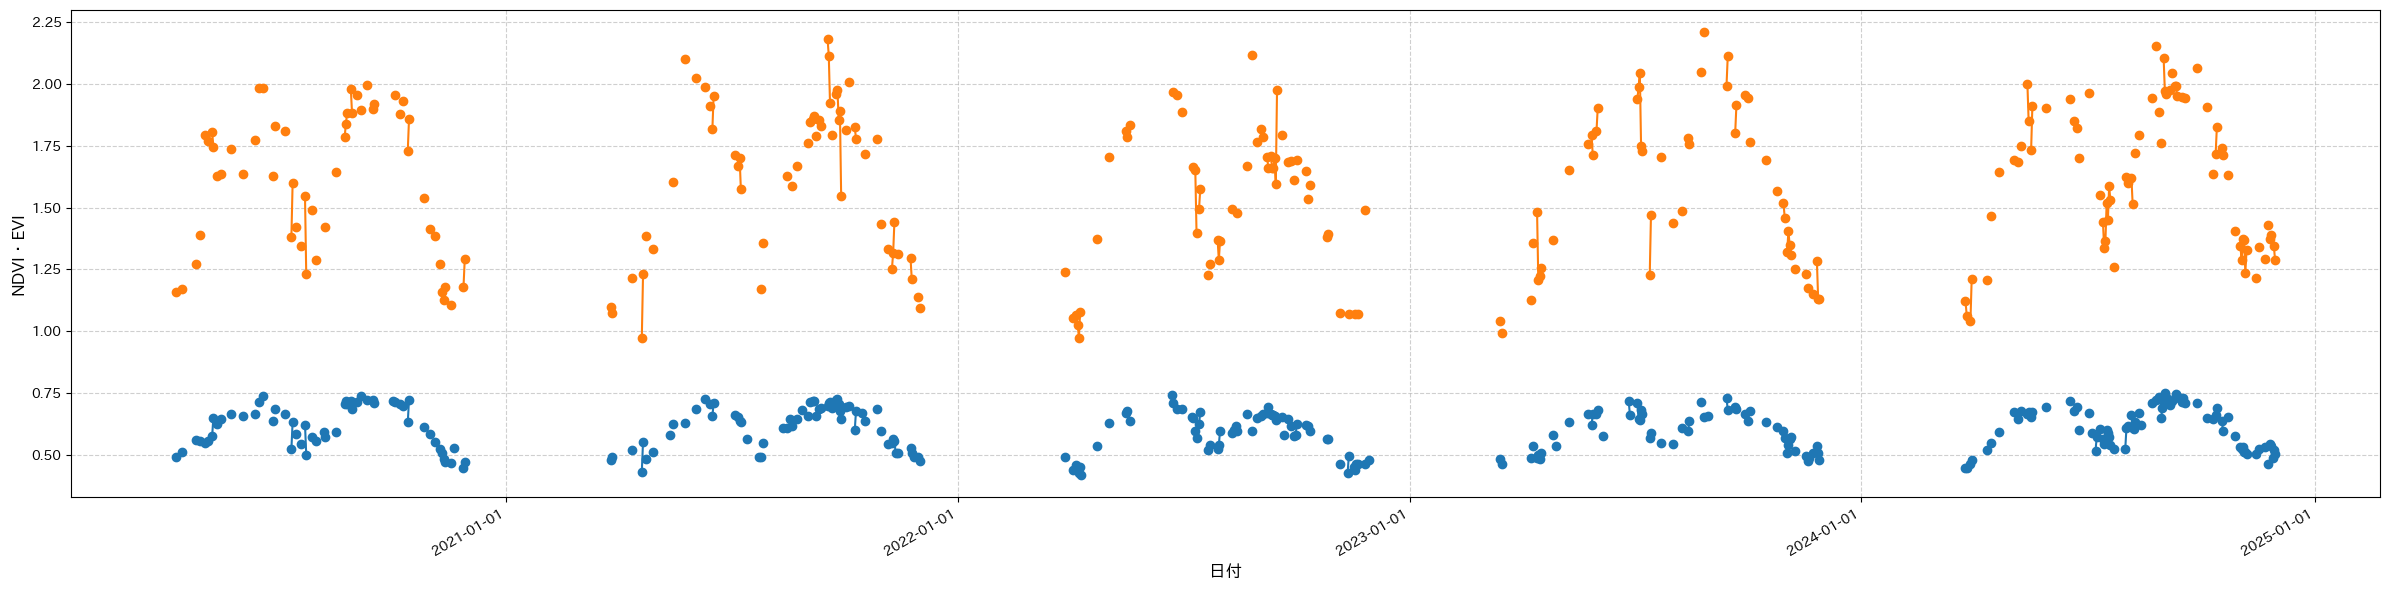

NDVIの元データ数：326
NDVIの外れ値処理後のデータ数：323
EVIの元データ数（極端な値は除去済み）：290
EVIの外れ値処理後のデータ数：285


In [183]:
df = df_vi.copy()

# EVIは分母が小さいと極端な値が出やすいためクリップ
df['evi'] = df['evi'].where((df['evi'] >= -10) & (df['evi'] <= 10), np.nan)

threshold = 2.0  # Zスコアの閾値

# Zスコアを計算
z_scores_ndvi = (df['ndvi'] - df['ndvi'].mean()) / df['ndvi'].std()
z_scores_evi = (df['evi'] - df['evi'].mean()) / df['evi'].std()

# 閾値を超えた外れ値を特定
outliers_ndvi = z_scores_ndvi.abs() > threshold
outliers_evi = z_scores_evi.abs() > threshold

# 外れ値をNaNに置き換える
df['ndvi_cleaned'] = df['ndvi'].copy()
df['evi_cleaned'] = df['evi'].copy()
df.loc[outliers_ndvi, 'ndvi_cleaned'] = np.nan
df.loc[outliers_evi, 'evi_cleaned'] = np.nan

# グラフの作成
fig, ax = plt.subplots(figsize=(24, 6))

# datetimeオブジェクトをX軸、nanmeansをY軸としてプロット
ax.plot(df['date'], df['ndvi_cleaned'], marker='o', linestyle='-')
# ax.plot(df['date'], df['ndvi'], marker='x', linestyle='-')

ax.plot(df['date'], df['evi_cleaned'], marker='o', linestyle='-')
# ax.plot(df['date'], df['evi'], marker='x', linestyle='-')

# ax.set_title('NDVIの時系列変化', fontsize=16)
ax.set_xlabel('日付', fontsize=12)
ax.set_ylabel('NDVI・EVI', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)

# X軸の日付フォーマットを見やすく設定
# 月と日を表示するフォーマッタ
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# ラベルが重ならないように自動で回転
fig.autofmt_xdate()

# Y軸の範囲をNDVIの典型的な値に設定（任意）
# ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

print(f"NDVIの元データ数：{df['ndvi'].count()}")
print(f"NDVIの外れ値処理後のデータ数：{df['ndvi_cleaned'].count()}")
print(f"EVIの元データ数（極端な値は除去済み）：{df['evi'].count()}")
print(f"EVIの外れ値処理後のデータ数：{df['evi_cleaned'].count()}")


#### 手動での修正・線形補間

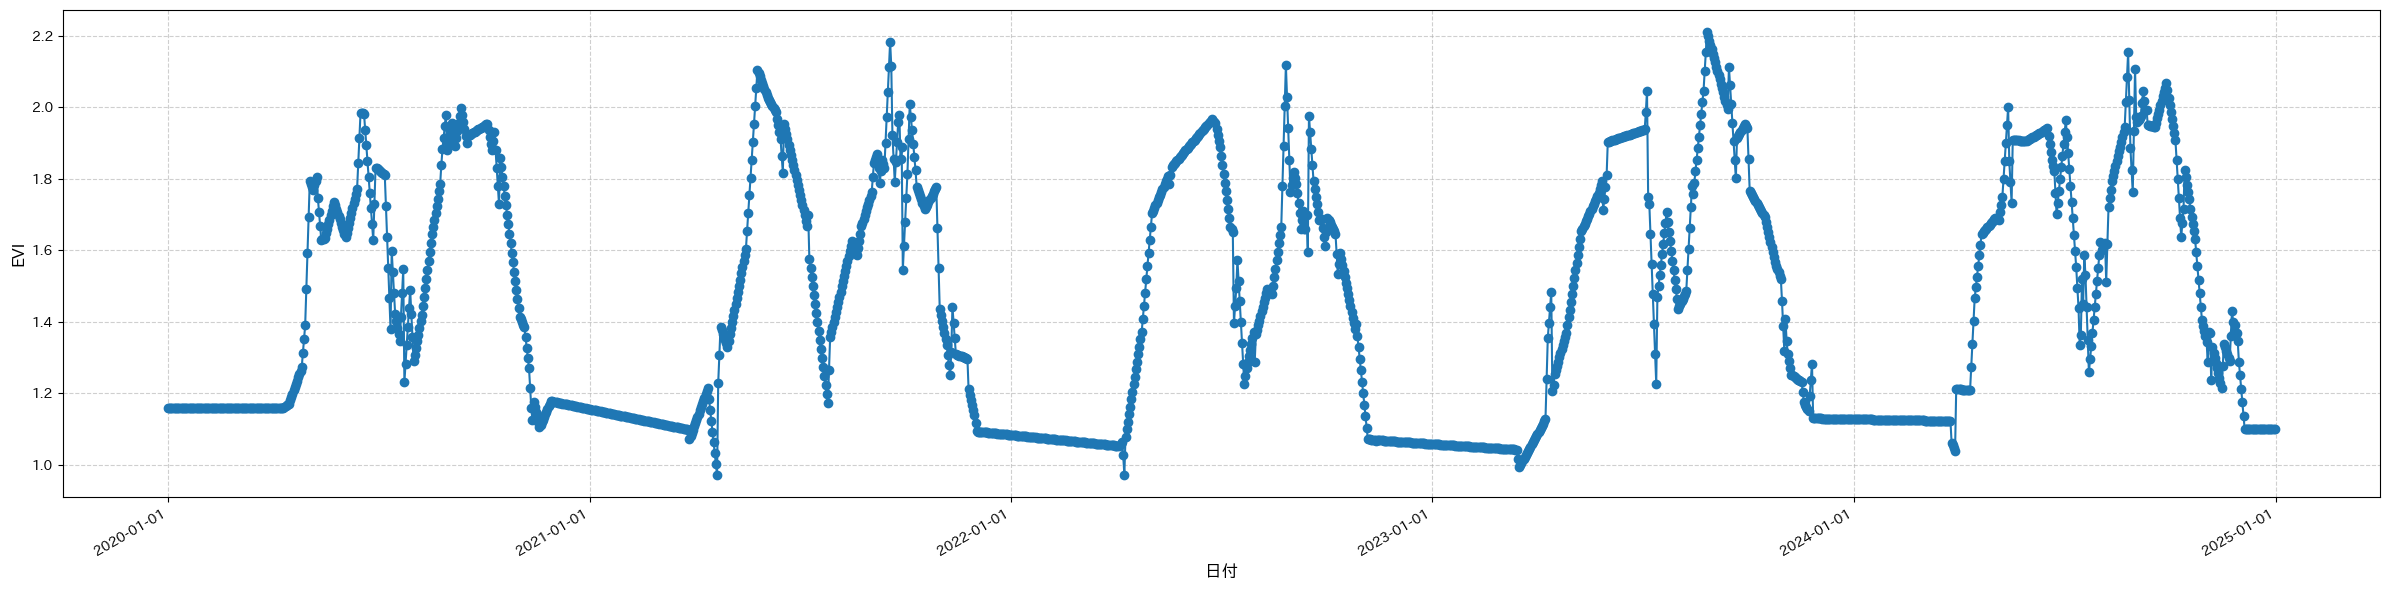

In [184]:
# 手動で値の修正
df.loc[df['date'] == pd.Timestamp('2020-11-29'), 'evi_cleaned'] = np.nan
df.loc[df['date'] == pd.Timestamp('2022-03-29'), 'evi_cleaned'] = np.nan
df.loc[df['date'] == pd.Timestamp('2022-11-26'), 'evi_cleaned'] = np.nan
df.loc[df['date'] == pd.Timestamp('2024-12-05'), 'evi_cleaned'] = 1.1
# 線形補間
df['evi_cleaned'] = df['evi_cleaned'].interpolate(method='linear')
# 前端を最初の非NaN値で埋める
df['evi_cleaned'] = df['evi_cleaned'].bfill()

##############################

# グラフの作成
fig, ax = plt.subplots(figsize=(24, 6))

# datetimeオブジェクトをX軸、nanmeansをY軸としてプロット
# ax.plot(df['date'], df['ndvi_cleaned'], marker='o', linestyle='-')
# ax.plot(df['date'], df['ndvi'], marker='x', linestyle='-')

ax.plot(df['date'], df['evi_cleaned'], marker='o', linestyle='-')
# ax.plot(df['date'], df['evi'], marker='x', linestyle='-')

# ax.set_title('NDVIの時系列変化', fontsize=16)
ax.set_xlabel('日付', fontsize=12)
ax.set_ylabel('EVI', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)

# X軸の日付フォーマットを見やすく設定
# 月と日を表示するフォーマッタ
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# ラベルが重ならないように自動で回転
fig.autofmt_xdate()

# Y軸の範囲をNDVIの典型的な値に設定（任意）
# ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()


#### 月半旬（5日ごと）でグループ化

    hanjun_start  evi_cleaned
0     2020-01-01      5.80089
1     2020-01-06      5.80089
2     2020-01-11      5.80089
3     2020-01-16      5.80089
4     2020-01-21      5.80089
..           ...          ...
355   2024-12-06      5.50000
356   2024-12-11      5.50000
357   2024-12-16      5.50000
358   2024-12-21      5.50000
359   2024-12-26      6.60000

[360 rows x 2 columns]


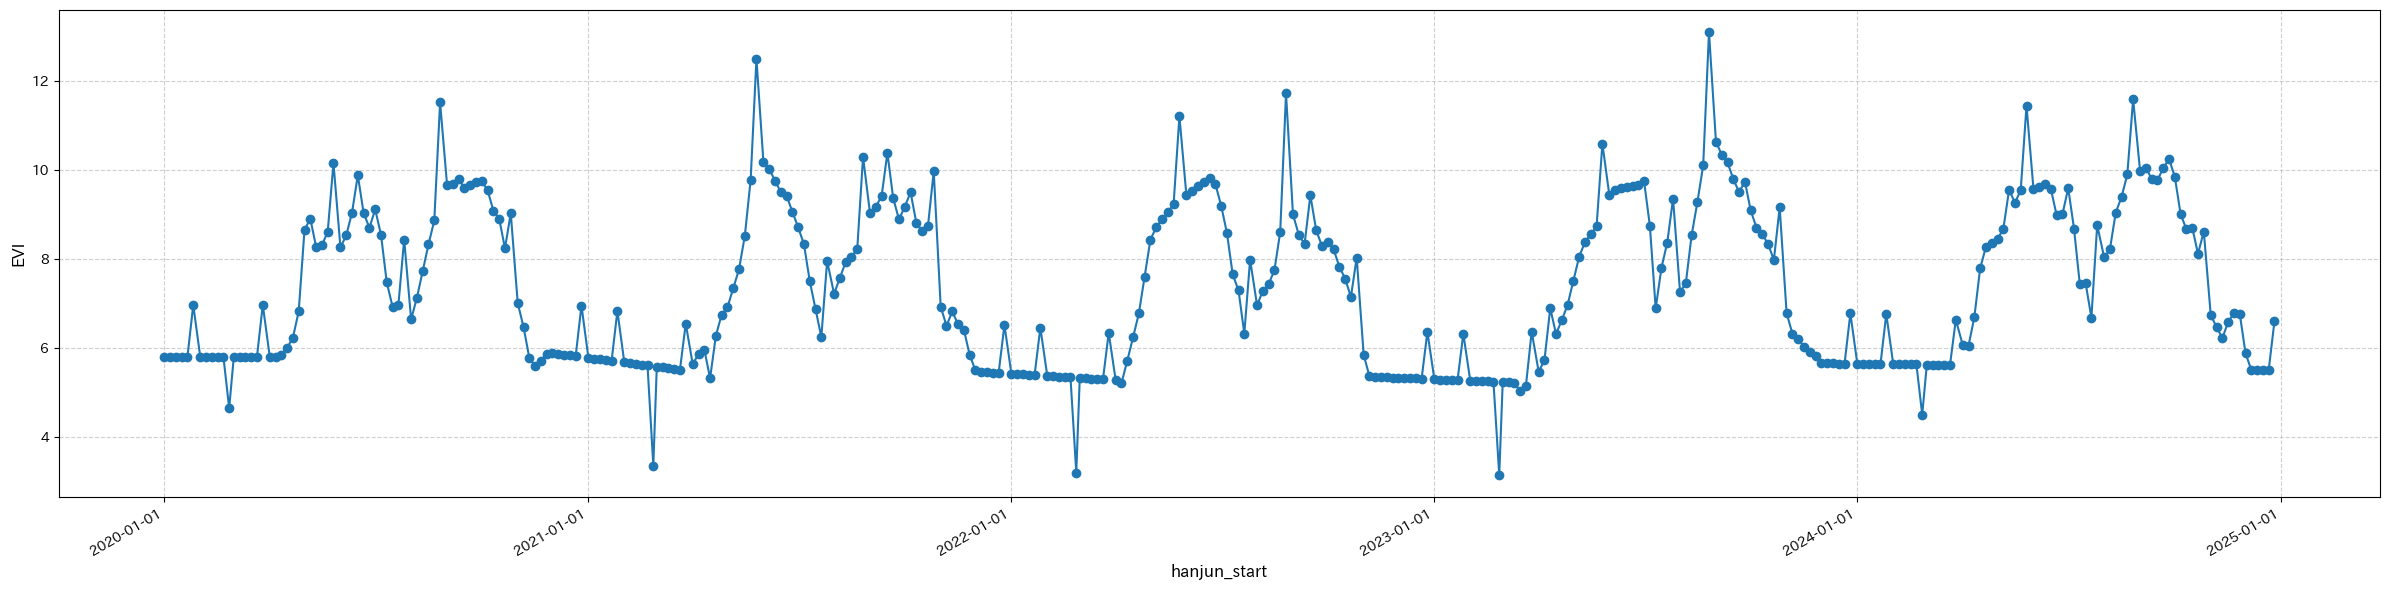

In [185]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

df['hanjun'] = pd.cut(
    df['day'],
    bins=[0, 5, 10, 15, 20, 25, 31], # 区切り
    labels=[1, 6, 11, 16, 21, 26]    # 月半旬開始日
)

df['hanjun_start'] = pd.to_datetime({
    'year': df['year'],
    'month': df['month'],
    'day': df['hanjun']
}, errors='raise')
df = df.sort_values('hanjun_start').reset_index(drop=True) # 時系列順にソート

df = df.groupby(['hanjun_start'], as_index=False)['evi_cleaned'].sum()

print(df)

##############################
fig, ax = plt.subplots(figsize=(24, 6))

ax.plot(df['hanjun_start'], df['evi_cleaned'], marker='o', linestyle='-')

# ax.set_title('NDVIの時系列変化', fontsize=16)
ax.set_xlabel('hanjun_start', fontsize=12)
ax.set_ylabel('EVI', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)

# X軸の日付フォーマットを見やすく設定
# 月と日を表示するフォーマッタ
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# ラベルが重ならないように自動で回転
fig.autofmt_xdate()

# Y軸の範囲をNDVIの典型的な値に設定（任意）
# ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()


#### Savitzky-Golayフィルタ
> SGフィルタは、周波数解析だけでなく、時系列データの平滑化にも広く利用されています。特に、信号の重要な特徴（ピークや谷など）を保持しながらノイズを除去できる点が特徴です。

https://zenn.dev/labcode/books/0b223bf990b383/viewer/mpojg7_1

##### パラメータ検討

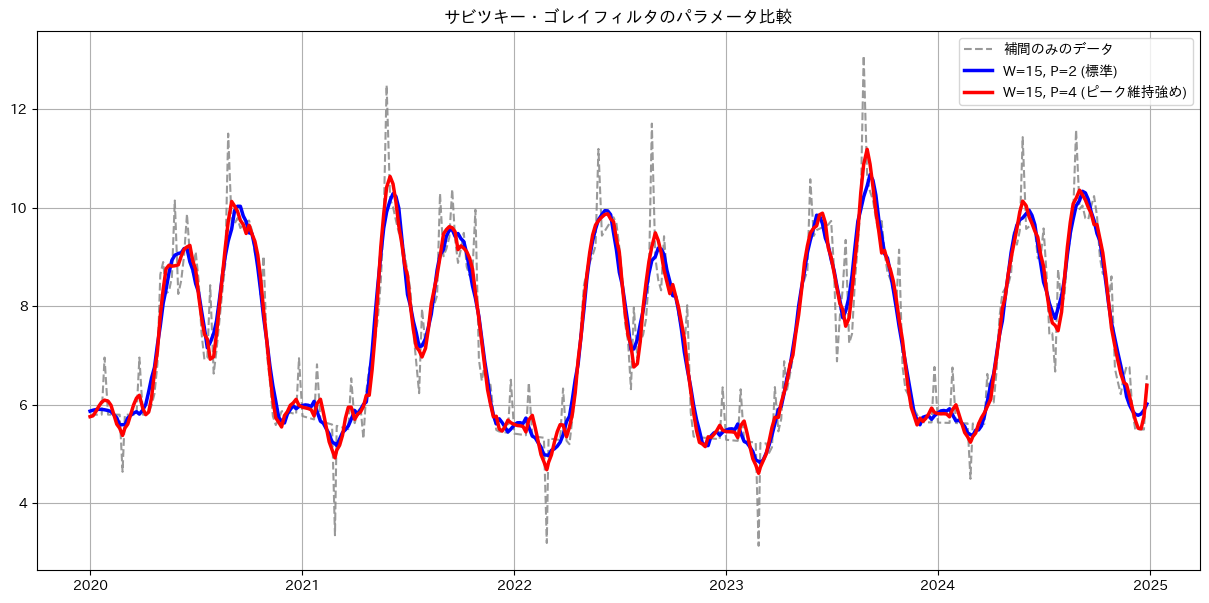

In [186]:
params_to_test = [
    {'window': 15, 'poly': 2, 'color': 'blue', 'label': 'W=15, P=2 (標準)'},
    # {'window': 31, 'poly': 2, 'color': 'red', 'label': 'W=31, P=2 (強め)'},
    {'window': 15, 'poly': 4, 'color': 'red', 'label': 'W=15, P=4 (ピーク維持強め)'},
]

# グラフで比較
plt.figure(figsize=(15, 7))
plt.plot(df['hanjun_start'], df['evi_cleaned'], label='補間のみのデータ', color='gray', linestyle='--', alpha=0.8)

for p in params_to_test:
    smoothed = savgol_filter(df['evi_cleaned'], window_length=p['window'], polyorder=p['poly'])
    plt.plot(df['hanjun_start'], smoothed, label=p['label'], color=p['color'], linewidth=2.5)

plt.title('サビツキー・ゴレイフィルタのパラメータ比較')
plt.legend()
plt.grid(True)
plt.show()


##### フィルタリング

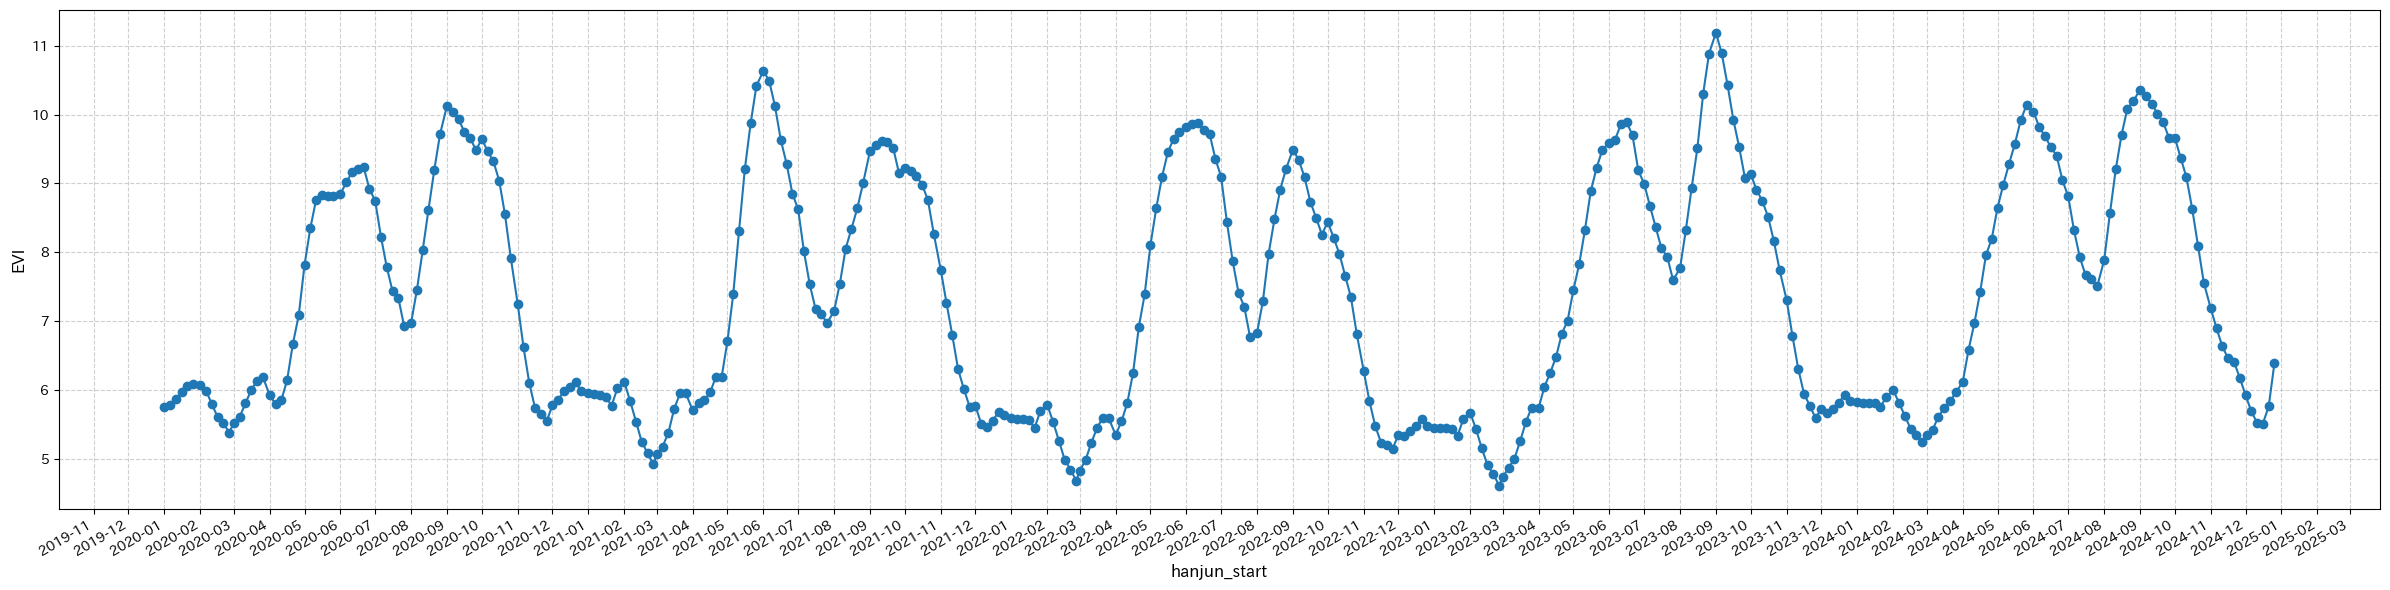

In [187]:
# サビツキー・ゴレイフィルタで全体を平滑化
# window_lengthは奇数，polyorderはwindow_lengthより小さい値を指定
df['evi_cleaned'] = savgol_filter(df['evi_cleaned'], window_length=15, polyorder=4)

##############################
fig, ax = plt.subplots(figsize=(24, 6))

ax.plot(df['hanjun_start'], df['evi_cleaned'], marker='o', linestyle='-')

# ax.set_title('NDVIの時系列変化', fontsize=16)
ax.set_xlabel('hanjun_start', fontsize=12)
ax.set_ylabel('EVI', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)

# X軸の日付フォーマットを見やすく設定
# 月と日を表示するフォーマッタ
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# ラベルが重ならないように自動で回転
fig.autofmt_xdate()

# Y軸の範囲をNDVIの典型的な値に設定（任意）
# ax.set_ylim(0, 1)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

plt.tight_layout()
plt.show()


#### 晩稲によるEVIの上昇を削除

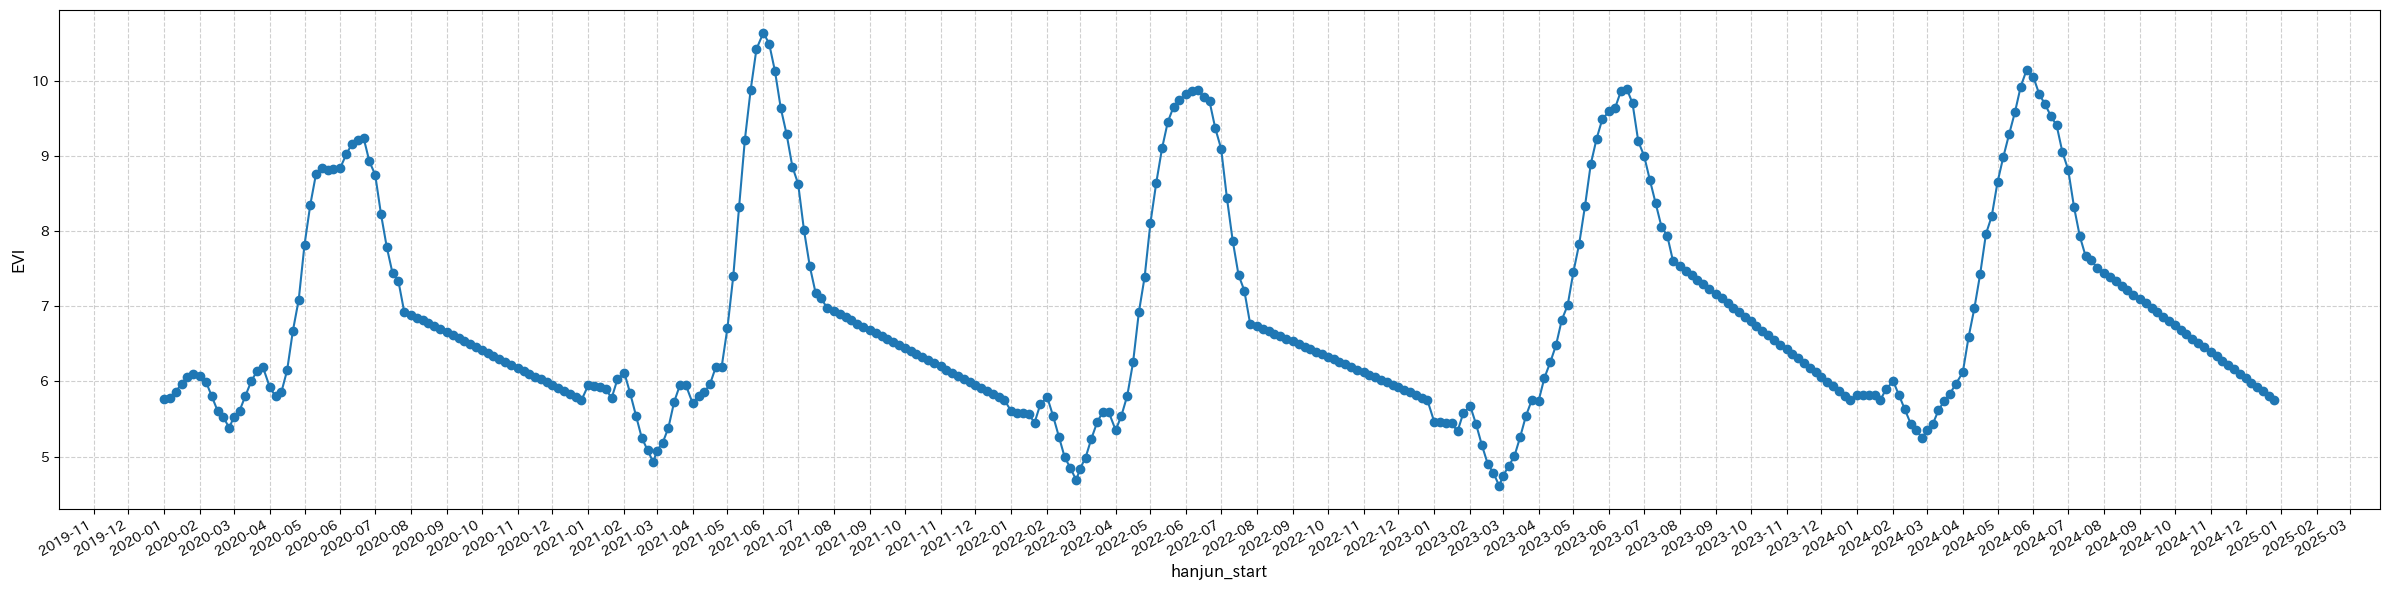

In [188]:
df.reset_index(drop=True, inplace=True) # indexの振り直し

for year in df['hanjun_start'].dt.year.unique():
    # その年のデータを抽出
    df_year = df[df['hanjun_start'].dt.year == year].copy()
    # 7, 8月のデータを抽出
    df_year_latter = df_year.loc[
        (df_year['hanjun_start'].dt.month >= 7) &
        (df_year['hanjun_start'].dt.month <= 8)
    ]

    # 早稲と晩稲の間にある谷の日付を特定
    valley_idx = df_year_latter['evi_cleaned'].idxmin() # 最小値をとるindexの特定
    valley_date = df_year_latter.loc[valley_idx + 1, 'hanjun_start'] # その次のindexに対応する日付

    # その年の 12/26 を作成
    end_date = pd.Timestamp(year=year, month=12, day=26)

    # valley_date ~ end_date の範囲を NaN にする
    mask = (df['hanjun_start'] >= valley_date) & (df['hanjun_start'] <= end_date)
    df.loc[mask, 'evi_cleaned'] = np.nan
    df.loc[df['hanjun_start'] == end_date, 'evi_cleaned'] = 5.75

df['evi_cleaned'] = df['evi_cleaned'].interpolate(method='linear') # 線形補間

##############################
fig, ax = plt.subplots(figsize=(24, 6))

ax.plot(df['hanjun_start'], df['evi_cleaned'], marker='o', linestyle='-')

# ax.set_title('NDVIの時系列変化', fontsize=16)
ax.set_xlabel('hanjun_start', fontsize=12)
ax.set_ylabel('EVI', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)

# X軸の日付フォーマットを見やすく設定
# 月と日を表示するフォーマッタ
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# ラベルが重ならないように自動で回転
fig.autofmt_xdate()

# Y軸の範囲をNDVIの典型的な値に設定（任意）
# ax.set_ylim(0, 1)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

plt.tight_layout()
plt.show()


#### 特徴量の作成

##### EVIのラグ特徴量

In [189]:
df_evi = df.copy()

for n in [6, 12, 18]:
    df_evi[f'EVI_{n}半旬前'] = df_evi['evi_cleaned'].shift(n) # n半旬ずらした特徴量
df_evi = df_evi.bfill()

df_evi


,hanjun_start,evi_cleaned,EVI_6半旬前,EVI_12半旬前,EVI_18半旬前
0,2020-01-01,5.760082,5.760082,5.760082,5.760082
1,2020-01-06,5.777486,5.760082,5.760082,5.760082
2,2020-01-11,5.864148,5.760082,5.760082,5.760082
3,2020-01-16,5.969706,5.760082,5.760082,5.760082
4,2020-01-21,6.055791,5.760082,5.760082,5.760082
...,...,...,...,...,...
355,2024-12-06,5.984022,6.335055,6.686088,7.037122
356,2024-12-11,5.925517,6.276550,6.627583,6.978616
357,2024-12-16,5.867011,6.218044,6.569077,6.920111
358,2024-12-21,5.808506,6.159539,6.510572,6.861605


##### EVIの微分のラグ特徴量

In [190]:
# N半旬前との差分を計算
df_evi['EVI_1半旬微分'] = df_evi['evi_cleaned'].diff(1)
df_evi['EVI_2半旬微分'] = df_evi['evi_cleaned'].diff(2)
df_evi['EVI_3半旬微分'] = df_evi['evi_cleaned'].diff(3)
df_evi['EVI_6半旬微分'] = df_evi['evi_cleaned'].diff(6)
df_evi = df_evi.bfill()

for n in [22]:
    df_evi[f'EVI_1半旬微分_{n}半旬前'] = df_evi['EVI_1半旬微分'].shift(n) # n半旬ずらした特徴量
    df_evi[f'EVI_2半旬微分_{n}半旬前'] = df_evi['EVI_2半旬微分'].shift(n) # n半旬ずらした特徴量
    df_evi[f'EVI_3半旬微分_{n}半旬前'] = df_evi['EVI_3半旬微分'].shift(n) # n半旬ずらした特徴量
    df_evi[f'EVI_6半旬微分_{n}半旬前'] = df_evi['EVI_6半旬微分'].shift(n) # n半旬ずらした特徴量
df_evi = df_evi.bfill()

df_evi.rename(columns={'evi_cleaned': 'EVI'}, inplace=True)

df_evi


,hanjun_start,EVI,EVI_6半旬前,EVI_12半旬前,EVI_18半旬前,EVI_1半旬微分,EVI_2半旬微分,EVI_3半旬微分,EVI_6半旬微分,EVI_1半旬微分_22半旬前,EVI_2半旬微分_22半旬前,EVI_3半旬微分_22半旬前,EVI_6半旬微分_22半旬前
0,2020-01-01,5.760082,5.760082,5.760082,5.760082,0.017404,0.104066,0.209624,0.315950,0.017404,0.104066,0.209624,0.315950
1,2020-01-06,5.777486,5.760082,5.760082,5.760082,0.017404,0.104066,0.209624,0.315950,0.017404,0.104066,0.209624,0.315950
2,2020-01-11,5.864148,5.760082,5.760082,5.760082,0.086662,0.104066,0.209624,0.315950,0.017404,0.104066,0.209624,0.315950
3,2020-01-16,5.969706,5.760082,5.760082,5.760082,0.105558,0.192221,0.209624,0.315950,0.017404,0.104066,0.209624,0.315950
4,2020-01-21,6.055791,5.760082,5.760082,5.760082,0.086085,0.191643,0.278305,0.315950,0.017404,0.104066,0.209624,0.315950
...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,2024-12-06,5.984022,6.335055,6.686088,7.037122,-0.058506,-0.117011,-0.175517,-0.351033,-0.058506,-0.117011,-0.175517,-0.394629
356,2024-12-11,5.925517,6.276550,6.627583,6.978616,-0.058506,-0.117011,-0.175517,-0.351033,-0.058506,-0.117011,-0.175517,-0.399903
357,2024-12-16,5.867011,6.218044,6.569077,6.920111,-0.058506,-0.117011,-0.175517,-0.351033,-0.058506,-0.117011,-0.175517,-0.351033
358,2024-12-21,5.808506,6.159539,6.510572,6.861605,-0.058506,-0.117011,-0.175517,-0.351033,-0.058506,-0.117011,-0.175517,-0.351033


#### 作図

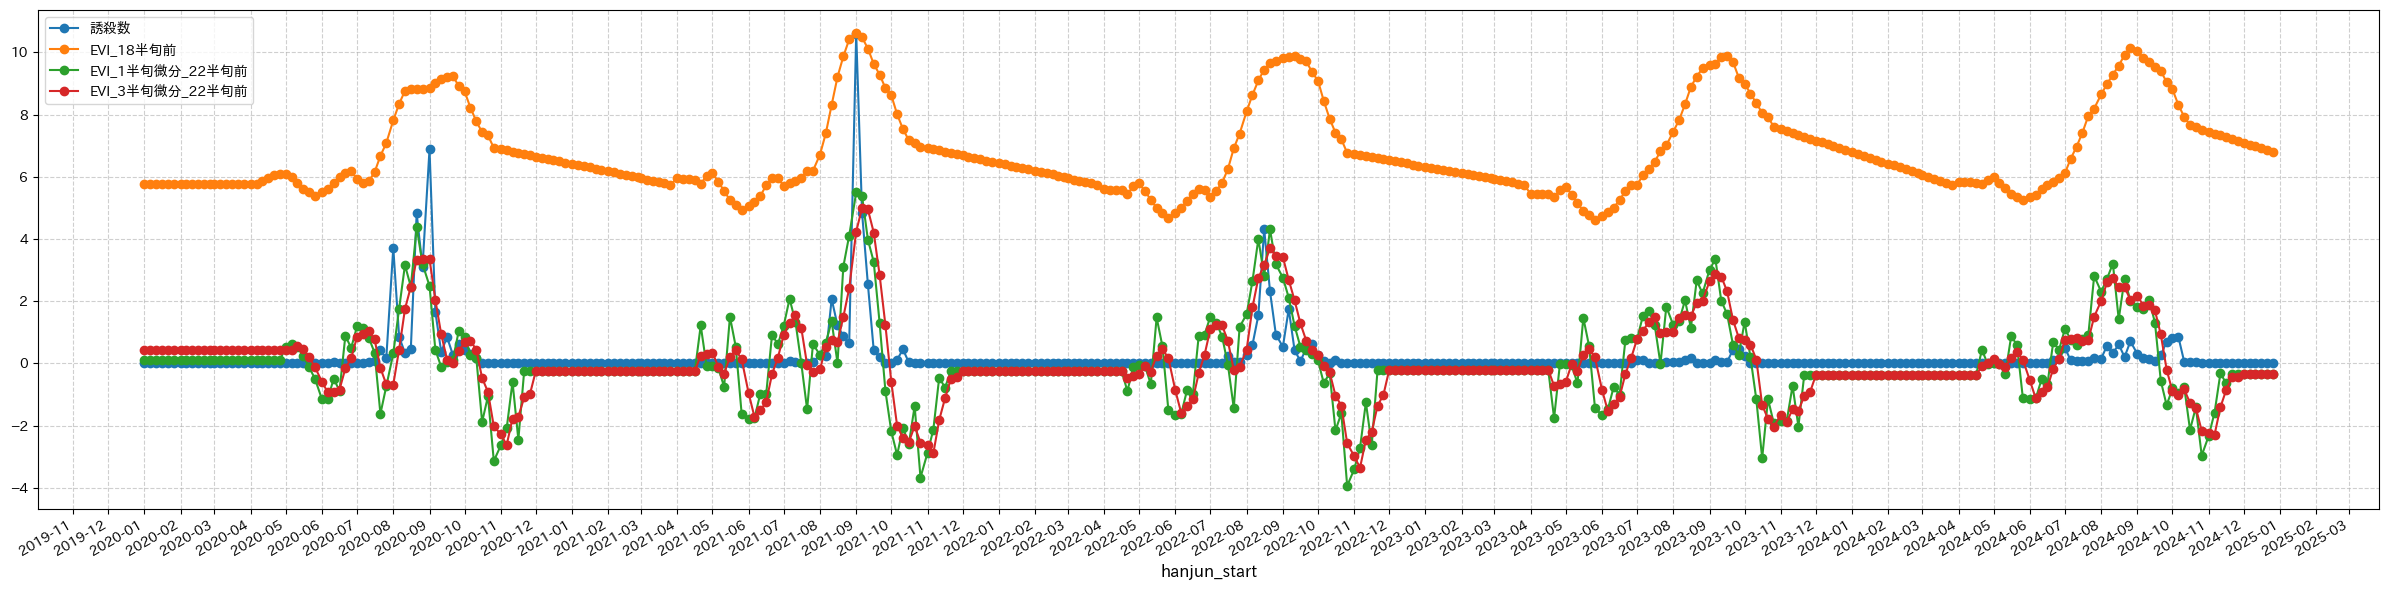

In [191]:
fig, ax = plt.subplots(figsize=(24, 6))

ax.plot(df_evi['hanjun_start'], df_resp["kill_score"] / 250, marker='o', linestyle='-', label='誘殺数')
ax.plot(df_evi['hanjun_start'], df_evi['EVI_18半旬前'], marker='o', linestyle='-', label='EVI_18半旬前')
ax.plot(df_evi['hanjun_start'], df_evi['EVI_1半旬微分_22半旬前'] * 6, marker='o', linestyle='-', label='EVI_1半旬微分_22半旬前')
# ax.plot(df_evi['hanjun_start'], df_evi['EVI_2半旬微分_22半旬前'] * 3, marker='o', linestyle='-', label='EVI_2半旬微分_22半旬前')
ax.plot(df_evi['hanjun_start'], df_evi['EVI_3半旬微分_22半旬前'] * 2, marker='o', linestyle='-', label='EVI_3半旬微分_22半旬前')
# ax.plot(df_evi['hanjun_start'], df_evi['EVI_6半旬微分_22半旬前'], marker='o', linestyle='-', label='EVI_6半旬微分_22半旬前')

# ax.set_title('NDVIの時系列変化', fontsize=16)
ax.set_xlabel('hanjun_start', fontsize=12)
# ax.set_ylabel('EVI', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)

# X軸の日付フォーマットを見やすく設定
# 月と日を表示するフォーマッタ
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# ラベルが重ならないように自動で回転
fig.autofmt_xdate()

# Y軸の範囲をNDVIの典型的な値に設定（任意）
# ax.set_ylim(0, 1)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

plt.legend()
plt.tight_layout()
plt.show()


### ３．降水量（香川県綾川町）

#### CSV生成

In [192]:
"""
# 香川県綾川町のAOI
kagawa_aoi = ee.Geometry.Rectangle([133.88869685989917, 34.173065973257714, 134.02820246756934, 34.269391919955304])

start_date = '2020-01-01'
end_date = '2025-01-01'

precip_collection = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
                      .filterDate(start_date, end_date) \
                      .select('precipitation')

# 日々の平均降水量を計算する関数
def get_daily_precip(image):
    mean_precip = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=kagawa_aoi,
        scale=5566 # CHIRPSの解像度
    ).get('precipitation')

    return ee.Feature(None, {
        'date': image.date().format('YYYY-MM-dd'),
        '降水量_香川': mean_precip
    })

# コレクションの各画像に適用
daily_precip_features = precip_collection.map(get_daily_precip)

# 結果をPythonクライアントに持ってくる
print("GEEから日別降水量データを取得しています...")
result = daily_precip_features.getInfo()

# GEEの結果（辞書のリスト）をpandasデータフレームに変換
features = result['features']
data_list = [{'date': f['properties']['date'], '降水量_香川': f['properties']['降水量_香川']} for f in features]

df_daily = pd.DataFrame(data_list)
df_daily.to_csv("df_daily_precip_kagawa.csv")
"""


'\n# 香川県綾川町のAOI\nkagawa_aoi = ee.Geometry.Rectangle([133.88869685989917, 34.173065973257714, 134.02820246756934, 34.269391919955304])\n\nstart_date = \'2020-01-01\'\nend_date = \'2025-01-01\'\n\nprecip_collection = ee.ImageCollection(\'UCSB-CHG/CHIRPS/DAILY\')                       .filterDate(start_date, end_date)                       .select(\'precipitation\')\n\n# 日々の平均降水量を計算する関数\ndef get_daily_precip(image):\n    mean_precip = image.reduceRegion(\n        reducer=ee.Reducer.mean(),\n        geometry=kagawa_aoi,\n        scale=5566 # CHIRPSの解像度\n    ).get(\'precipitation\')\n\n    return ee.Feature(None, {\n        \'date\': image.date().format(\'YYYY-MM-dd\'),\n        \'降水量_香川\': mean_precip\n    })\n\n# コレクションの各画像に適用\ndaily_precip_features = precip_collection.map(get_daily_precip)\n\n# 結果をPythonクライアントに持ってくる\nprint("GEEから日別降水量データを取得しています...")\nresult = daily_precip_features.getInfo()\n\n# GEEの結果（辞書のリスト）をpandasデータフレームに変換\nfeatures = result[\'features\']\ndata_list = [{\'date\': f[

#### CSV読み込み

    hanjun_start     降水量_香川
0     2020-01-01   0.000000
1     2020-01-06   0.000000
2     2020-01-11   0.000000
3     2020-01-16   0.000000
4     2020-01-21  25.991853
..           ...        ...
355   2024-12-06   4.970965
356   2024-12-11   0.000000
357   2024-12-16   0.561192
358   2024-12-21   0.000000
359   2024-12-26   3.539907

[360 rows x 2 columns]


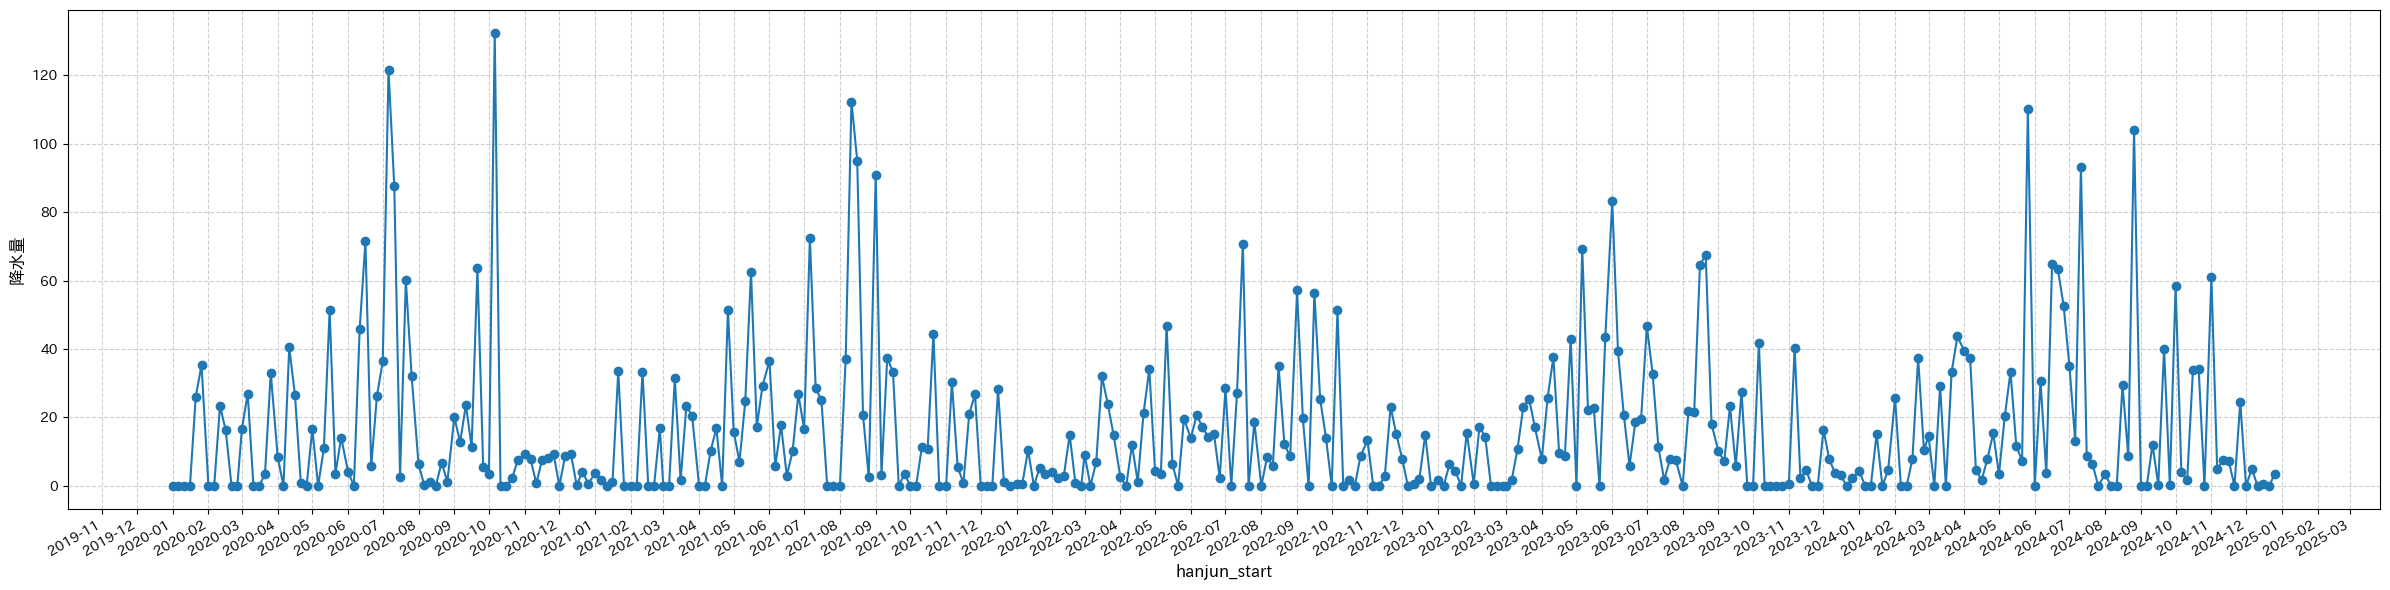

In [193]:
path = (
    "https://github.com/ShotaSasaki-HU/ASTRO-CAMP-2025/raw/refs/heads/main/data"
    "/df_daily_precip_kagawa.csv"
)
df_daily = pd.read_csv(path, encoding="utf-8", header=0, index_col=0)

# date列をdatetime型に変換
df_daily['date'] = pd.to_datetime(df_daily['date'])

df_daily['year'] = df_daily['date'].dt.year
df_daily['month'] = df_daily['date'].dt.month
df_daily['day'] = df_daily['date'].dt.day

df_daily['hanjun'] = pd.cut(
    df_daily['day'],
    bins=[0, 5, 10, 15, 20, 25, 31], # 区切り
    labels=[1, 6, 11, 16, 21, 26]    # 月半旬開始日
)

df_daily['hanjun_start'] = pd.to_datetime({
    'year': df_daily['year'],
    'month': df_daily['month'],
    'day': df_daily['hanjun']
}, errors='raise')
df_daily = df_daily.sort_values('hanjun_start').reset_index(drop=True) # 時系列順にソート

df_precip_kagawa = df_daily.groupby(['hanjun_start'], as_index=False)['降水量_香川'].sum()

print(df_precip_kagawa)

##############################
fig, ax = plt.subplots(figsize=(24, 6))

ax.plot(df_precip_kagawa['hanjun_start'], df_precip_kagawa['降水量_香川'], marker='o', linestyle='-')

# ax.set_title('NDVIの時系列変化', fontsize=16)
ax.set_xlabel('hanjun_start', fontsize=12)
ax.set_ylabel('降水量', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)

# X軸の日付フォーマットを見やすく設定
# 月と日を表示するフォーマッタ
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# ラベルが重ならないように自動で回転
fig.autofmt_xdate()

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

plt.tight_layout()
plt.show()


#### Savitzky-Golayフィルタ

##### パラメータ検討

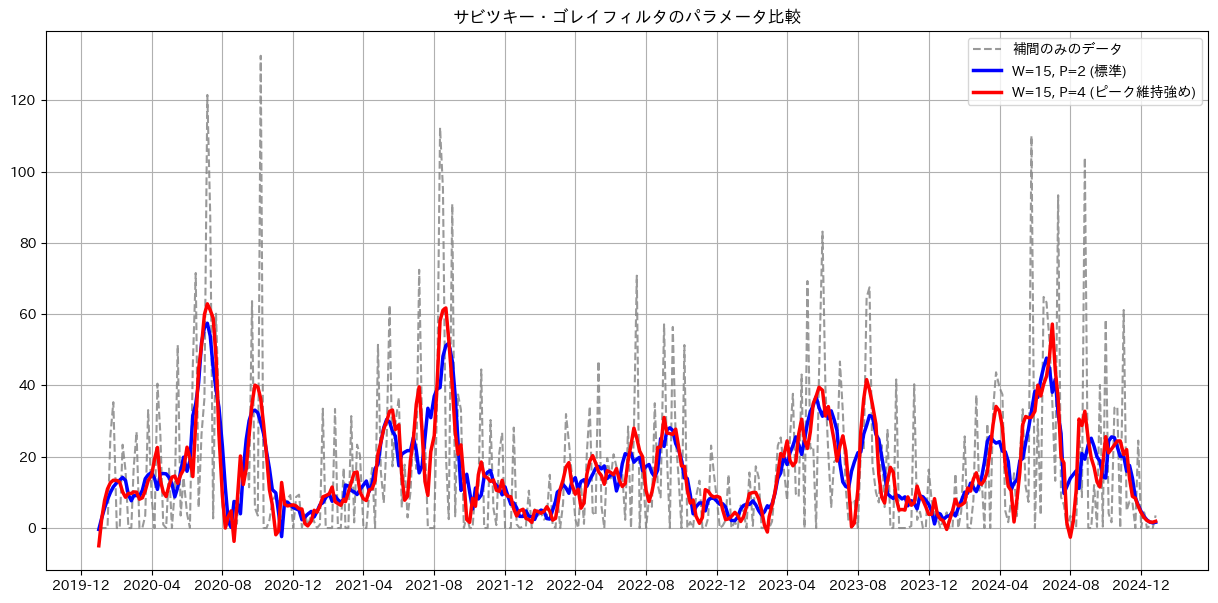

In [194]:
params_to_test = [
    {'window': 15, 'poly': 2, 'color': 'blue', 'label': 'W=15, P=2 (標準)'},
    # {'window': 31, 'poly': 2, 'color': 'red', 'label': 'W=31, P=2 (強め)'},
    {'window': 15, 'poly': 4, 'color': 'red', 'label': 'W=15, P=4 (ピーク維持強め)'},
]

# グラフで比較
plt.figure(figsize=(15, 7))
plt.plot(df_precip_kagawa['hanjun_start'], df_precip_kagawa['降水量_香川'], label='補間のみのデータ', color='gray', linestyle='--', alpha=0.8)

for p in params_to_test:
    smoothed = savgol_filter(df_precip_kagawa['降水量_香川'], window_length=p['window'], polyorder=p['poly'])
    plt.plot(df_precip_kagawa['hanjun_start'], smoothed, label=p['label'], color=p['color'], linewidth=2.5)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

plt.title('サビツキー・ゴレイフィルタのパラメータ比較')
plt.legend()
plt.grid(True)
plt.show()


##### フィルタリング

In [195]:
# サビツキー・ゴレイフィルタで全体を平滑化
# window_lengthは奇数，polyorderはwindow_lengthより小さい値を指定
df_precip_kagawa['降水量_香川'] = savgol_filter(df_precip_kagawa['降水量_香川'], window_length=15, polyorder=2)

#### ラグ特徴量

In [196]:
for n in range(6, 8+1, 1):
    df_precip_kagawa[f'降水量_香川_{n}半旬前'] = df_precip_kagawa['降水量_香川'].shift(n) # n半旬ずらした特徴量
df_precip_kagawa = df_precip_kagawa.bfill()

df_precip_kagawa[f'降水量_香川_6-8半旬前の和'] =\
    df_precip_kagawa[f'降水量_香川_6半旬前'] +\
    df_precip_kagawa[f'降水量_香川_7半旬前'] +\
    df_precip_kagawa[f'降水量_香川_8半旬前']

df_precip_kagawa


,hanjun_start,降水量_香川,降水量_香川_6半旬前,降水量_香川_7半旬前,降水量_香川_8半旬前,降水量_香川_6-8半旬前の和
0,2020-01-01,-0.398837,-0.398837,-0.398837,-0.398837,-1.196511
1,2020-01-06,2.812969,-0.398837,-0.398837,-0.398837,-1.196511
2,2020-01-11,5.614238,-0.398837,-0.398837,-0.398837,-1.196511
3,2020-01-16,8.004969,-0.398837,-0.398837,-0.398837,-1.196511
4,2020-01-21,9.985162,-0.398837,-0.398837,-0.398837,-1.196511
...,...,...,...,...,...,...
355,2024-12-06,3.266256,15.939223,20.153907,20.084108,56.177238
356,2024-12-11,2.275742,17.557131,15.939223,20.153907,53.650261
357,2024-12-16,1.670360,14.026973,17.557131,15.939223,47.523327
358,2024-12-21,1.450113,8.548601,14.026973,17.557131,40.132705


#### 作図

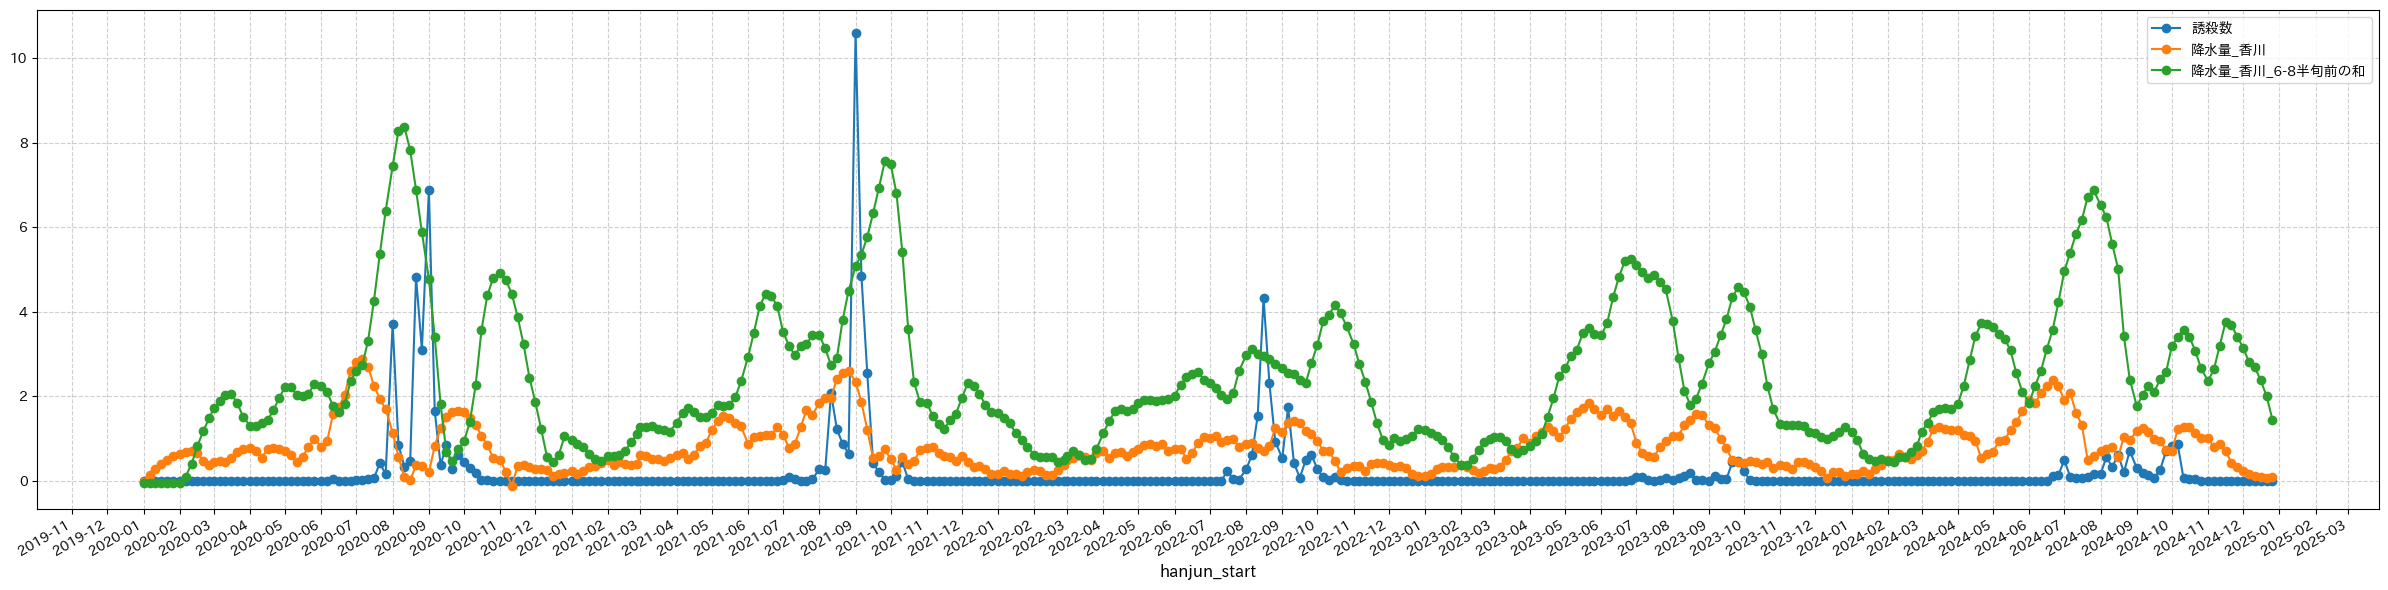

In [220]:
fig, ax = plt.subplots(figsize=(24, 6))

ax.plot(df_precip_kagawa['hanjun_start'], df_resp["kill_score"] / 250, marker='o', linestyle='-', label='誘殺数')
ax.plot(df_precip_kagawa['hanjun_start'], df_precip_kagawa[f'降水量_香川'] / 20, marker='o', linestyle='-', label='降水量_香川')
ax.plot(df_precip_kagawa['hanjun_start'], df_precip_kagawa[f'降水量_香川_6-8半旬前の和'] / 20, marker='o', linestyle='-', label='降水量_香川_6-8半旬前の和')
# ax.plot(df_precip_kagawa['hanjun_start'], df_precip_kagawa[f'降水量_香川_6半旬前'] / 20, marker='o', linestyle='-', label='降水量_香川_6半旬前')
# ax.plot(df_precip_kagawa['hanjun_start'], df_precip_kagawa[f'降水量_香川_7半旬前'] / 20, marker='o', linestyle='-', label='降水量_香川_7半旬前')
# ax.plot(df_precip_kagawa['hanjun_start'], df_precip_kagawa[f'降水量_香川_8半旬前'] / 20, marker='o', linestyle='-', label='降水量_香川_8半旬前')

# ax.set_title('NDVIの時系列変化', fontsize=16)
ax.set_xlabel('hanjun_start', fontsize=12)
# ax.set_ylabel('EVI', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)

# X軸の日付フォーマットを見やすく設定
# 月と日を表示するフォーマッタ
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# ラベルが重ならないように自動で回転
fig.autofmt_xdate()

# Y軸の範囲をNDVIの典型的な値に設定（任意）
# ax.set_ylim(0, 1)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

plt.legend()
plt.tight_layout()
plt.show()


### ４．積算温度（香川県綾川町）

#### CSV生成

In [198]:
"""
aoi = ee.Geometry.Rectangle([133.88869685989917, 34.173065973257714, 134.02820246756934, 34.269391919955304])
developmental_zero = 12.0 # 発育下限温度（発育零点）
PERIOD_DAYS = 5

# 指定された期間の積算温度を計算する関数
def get_degree_days_for_period(start_date, end_date):
    ee_start_date = ee.Date(start_date.strftime('%Y-%m-%d'))
    ee_end_date = ee.Date(end_date.strftime('%Y-%m-%d'))
    days_in_period = ee_end_date.difference(ee_start_date, 'day')

    # 指定した月半旬のMODIS画像コレクションを取得
    collection = ee.ImageCollection('MODIS/061/MOD11A1').filterDate(ee_start_date, ee_end_date)

    # --- ここからが積算温度の計算部分 ---

    # 期間内の画像枚数をサーバーサイドでカウント
    image_count = collection.size()

    # 画像が1枚以上ある場合の関数
    def calculate_stats(img_collection):
        # 日々の積算温度を計算する関数
        def calculate_degree_days(image):
            # LSTバンドを選択し，スケール変換と単位変換（ケルビン -> 摂氏）．
            temp_celsius = image.select('LST_Day_1km').multiply(0.02).subtract(273.15)
            # (気温 - 基準温度) を計算．結果がマイナスなら0にする．
            degree_day = temp_celsius.subtract(developmental_zero).max(0)
            return degree_day

        # コレクション内の各画像（各日）に対して上記の関数を適用
        daily_degree_days = collection.map(calculate_degree_days)

        # 期間内の日平均積算温度を計算し、期間の日数を掛けて正規化
        total_degree_days_image = daily_degree_days.mean().multiply(days_in_period).rename('Degree_Days')

        # AOI内の平均値を計算
        stats = total_degree_days_image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=aoi,
            scale=1000,
            maxPixels=1e9
        )
        return stats

    # 画像が0枚だった場合の関数
    def empty_case():
        return ee.Dictionary({'Degree_Days': None})

    # image_count > 0 の条件で分岐を実行
    # ee.Algorithms.If(condition, true_case, false_case)
    # greater than(0)
    stats = ee.Dictionary(ee.Algorithms.If(image_count.gt(0), calculate_stats(collection), empty_case()))

    return stats.getInfo().get('Degree_Days')

lagged_features = [] # 遅延した特徴量たち
dd_cache = {} # 計算結果を保存するキャッシュ用の辞書

for index, row in tqdm(df_resp.iterrows(), total=df_resp.shape[0], desc="積算温度を計算中"):
    current_start = row['hanjun_start']

    row_features = {} # 計算結果を格納する辞書
    row_features['hanjun_start'] = current_start

    # 1半旬前からN半旬前までをループ処理
    N = 18
    for lag in range(1, N + 1):
        start_lag = current_start - pd.Timedelta(days=PERIOD_DAYS * lag)
        end_lag = current_start - pd.Timedelta(days=PERIOD_DAYS * (lag - 1))

        # キャッシュキーを作成
        cache_key = start_lag.strftime('%Y-%m-%d')

        # キャッシュの確認
        if cache_key in dd_cache:
            # キャッシュがある場合
            dd_value = dd_cache[cache_key]
        else:
            # キャッシュが無い場合
            dd_value = get_degree_days_for_period(start_lag, end_lag)
            dd_cache[cache_key] = dd_value

        row_features[f'積算温度_香川県_{lag}半旬前'] = dd_value

    lagged_features.append(row_features)

# 計算結果のリストを新しいデータフレームに変換
df_degree_days = pd.DataFrame(lagged_features)

# NaN値の線形補間を実行（月半旬が短いためデータが無い場合あり）
df_degree_days.interpolate(method='linear', inplace=True)
df_degree_days = df_degree_days.bfill() # 前端のNaN値は補間されていないため．

aoi_info = aoi.getInfo()
coords = aoi_info['coordinates'][0]
min_lon = coords[0][0]
min_lat = coords[0][1]
max_lon = coords[2][0]
max_lat = coords[2][1]
file_name = f"df_degree_days_[{min_lon}, {min_lat}, {max_lon}, {max_lat}].csv"
df_degree_days.to_csv(file_name)

df_degree_days
"""


'\naoi = ee.Geometry.Rectangle([133.88869685989917, 34.173065973257714, 134.02820246756934, 34.269391919955304])\ndevelopmental_zero = 12.0 # 発育下限温度（発育零点）\nPERIOD_DAYS = 5\n\n# 指定された期間の積算温度を計算する関数\ndef get_degree_days_for_period(start_date, end_date):\n    ee_start_date = ee.Date(start_date.strftime(\'%Y-%m-%d\'))\n    ee_end_date = ee.Date(end_date.strftime(\'%Y-%m-%d\'))\n    days_in_period = ee_end_date.difference(ee_start_date, \'day\')\n\n    # 指定した月半旬のMODIS画像コレクションを取得\n    collection = ee.ImageCollection(\'MODIS/061/MOD11A1\').filterDate(ee_start_date, ee_end_date)\n\n    # --- ここからが積算温度の計算部分 ---\n\n    # 期間内の画像枚数をサーバーサイドでカウント\n    image_count = collection.size()\n\n    # 画像が1枚以上ある場合の関数\n    def calculate_stats(img_collection):\n        # 日々の積算温度を計算する関数\n        def calculate_degree_days(image):\n            # LSTバンドを選択し，スケール変換と単位変換（ケルビン -> 摂氏）．\n            temp_celsius = image.select(\'LST_Day_1km\').multiply(0.02).subtract(273.15)\n            # (気温 - 基準温度) を計算．結果がマイナスなら0にする．\

#### CSV読み込み

In [222]:
path = (
    "https://github.com/ShotaSasaki-HU/ASTRO-CAMP-2025/raw/refs/heads/main/data"
    "/df_degree_days_%5B133.88869685989917,%2034.173065973257714,"
    "%20134.02820246756934,%2034.269391919955304%5D.csv"
)
df_degree_days_kagawa = pd.read_csv(path, encoding="utf-8", header=0, index_col=0)
df_degree_days_kagawa['hanjun_start'] = pd.to_datetime(df_degree_days_kagawa['hanjun_start'], errors="raise")

print(df_degree_days_kagawa)


    hanjun_start  積算温度_香川県_1半旬前  積算温度_香川県_2半旬前  積算温度_香川県_3半旬前  積算温度_香川県_4半旬前  \
0     2020-01-01       0.000000       2.877085       0.002807       1.742308   
1     2020-01-06       0.000963       0.000000       2.877085       0.002807   
2     2020-01-11       0.686354       0.000963       0.000000       2.877085   
3     2020-01-16       0.000000       0.686354       0.000963       0.000000   
4     2020-01-21       0.000092       0.000000       0.686354       0.000963   
..           ...            ...            ...            ...            ...   
355   2024-12-06       7.073863       0.000000       8.642391       6.039008   
356   2024-12-11       0.323956       7.073863       0.000000       8.642391   
357   2024-12-16       0.000000       0.323956       7.073863       0.000000   
358   2024-12-21       0.000000       0.000000       0.323956       7.073863   
359   2024-12-26       0.000000       0.000000       0.000000       0.323956   

     積算温度_香川県_5半旬前  積算温度_香川県_6半旬前  積算温度

#### 変換

In [278]:
df_degree_days_kagawa[f'積算温度_香川県_6半旬前_変換'] = df_degree_days_kagawa[f'積算温度_香川県_6半旬前'] * (df_degree_days_kagawa[f'積算温度_香川県_6半旬前'] - 90)
df_degree_days_kagawa[f'積算温度_香川県_6半旬前_変換'] = df_degree_days_kagawa[f'積算温度_香川県_6半旬前_変換'].clip(lower=0) # 負の値は0へ置き換え


#### 作図

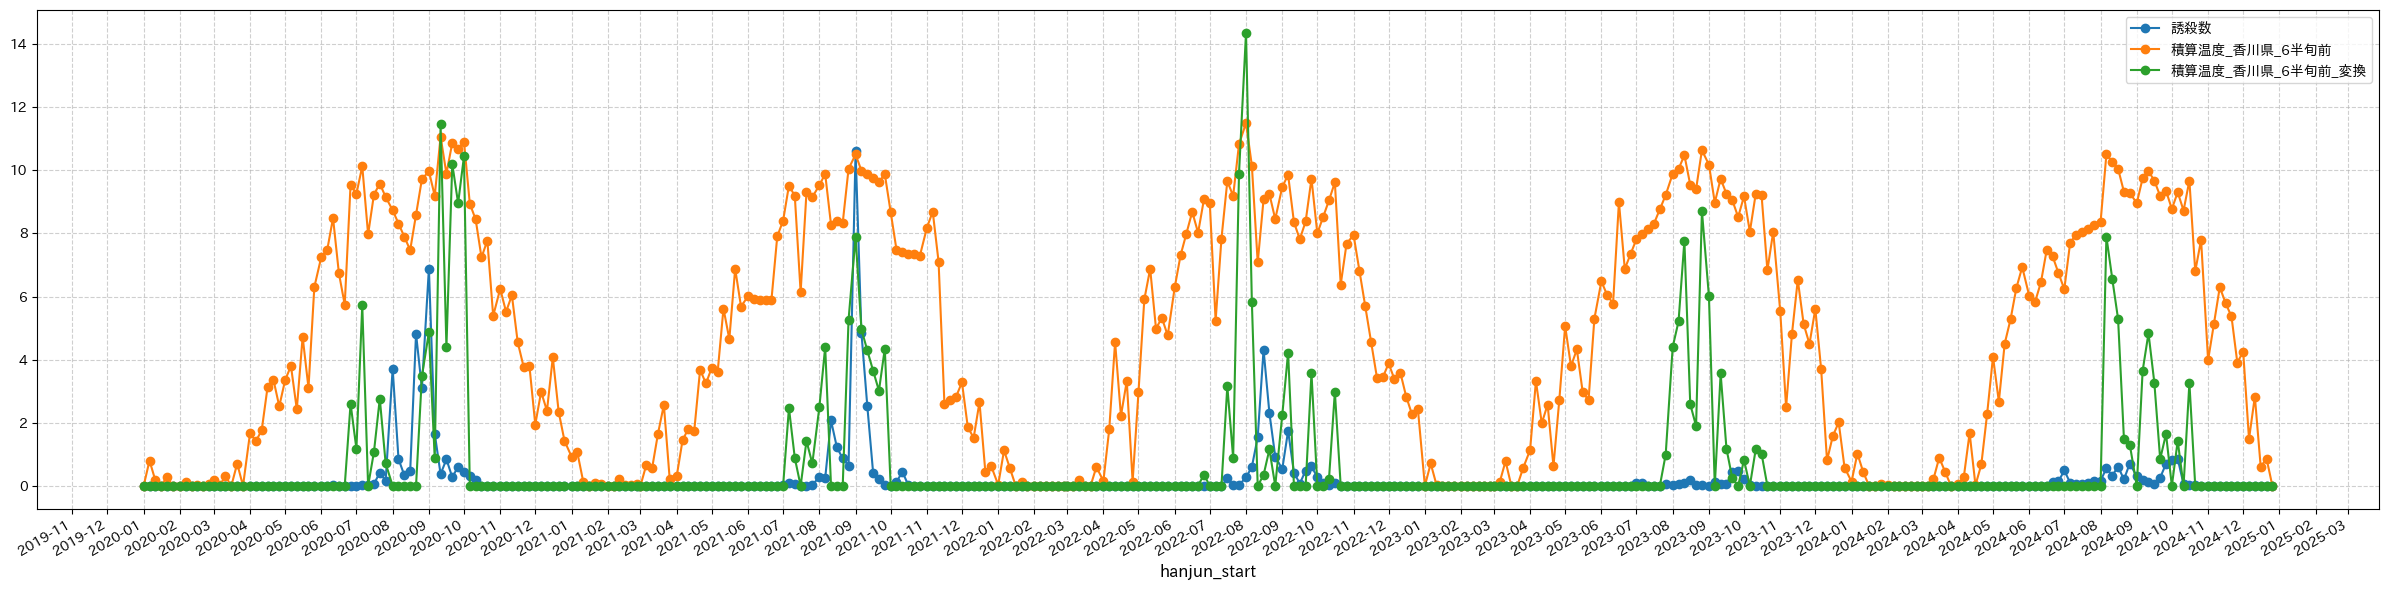

In [279]:
fig, ax = plt.subplots(figsize=(24, 6))

ax.plot(df_degree_days_kagawa['hanjun_start'], df_resp["kill_score"] / 250, marker='o', linestyle='-', label='誘殺数')
ax.plot(df_degree_days_kagawa['hanjun_start'], df_degree_days_kagawa[f'積算温度_香川県_6半旬前'] / 10, marker='o', linestyle='-', label='積算温度_香川県_6半旬前')
ax.plot(df_degree_days_kagawa['hanjun_start'], df_degree_days_kagawa[f'積算温度_香川県_6半旬前_変換'] / 200, marker='o', linestyle='-', label='積算温度_香川県_6半旬前_変換')

# ax.set_title('NDVIの時系列変化', fontsize=16)
ax.set_xlabel('hanjun_start', fontsize=12)
# ax.set_ylabel('EVI', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)

# X軸の日付フォーマットを見やすく設定
# 月と日を表示するフォーマッタ
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# ラベルが重ならないように自動で回転
fig.autofmt_xdate()

# Y軸の範囲をNDVIの典型的な値に設定（任意）
# ax.set_ylim(-5, 15)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

plt.legend()
plt.tight_layout()
plt.show()


## 目的変数と説明変数の結合

### 結合

In [200]:
df = df_resp.copy()

df = df.merge(df_degree_days_fujian, on='hanjun_start', how='left')
df = df.merge(df_evi, on='hanjun_start', how='left')
df = df.merge(df_precip_kagawa, on='hanjun_start', how='left')
df = df.merge(df_degree_days_kagawa, on='hanjun_start', how='left')

print("元の列:", list(df.columns))
print()

df = df[['hanjun_start', 'kill_score', 'EVI_1半旬微分_22半旬前', '積算温度_香川県_6半旬前_変換']]

print(df)


元の列: ['hanjun_start', 'kill_score', '積算温度_福建省_6半旬前', '積算温度_福建省_12半旬前', '積算温度_福建省_18半旬前', 'EVI', 'EVI_6半旬前', 'EVI_12半旬前', 'EVI_18半旬前', 'EVI_1半旬微分', 'EVI_2半旬微分', 'EVI_3半旬微分', 'EVI_6半旬微分', 'EVI_1半旬微分_22半旬前', 'EVI_2半旬微分_22半旬前', 'EVI_3半旬微分_22半旬前', 'EVI_6半旬微分_22半旬前', '降水量_香川', '降水量_香川_6半旬前', '降水量_香川_7半旬前', '降水量_香川_8半旬前', '降水量_香川_6-8半旬前の和', '積算温度_香川県_6半旬前', '積算温度_香川県_12半旬前', '積算温度_香川県_18半旬前']

    hanjun_start  kill_score  EVI_18半旬前  EVI_1半旬微分_22半旬前
0     2020-01-01           0   5.760082         0.017404
1     2020-01-06           0   5.760082         0.017404
2     2020-01-11           0   5.760082         0.017404
3     2020-01-16           0   5.760082         0.017404
4     2020-01-21           0   5.760082         0.017404
..           ...         ...        ...              ...
355   2024-12-06           0   7.037122        -0.058506
356   2024-12-11           0   6.978616        -0.058506
357   2024-12-16           0   6.920111        -0.058506
358   2024-12-21           0   6.861605 

### データの正規化（スキップ）

In [201]:
# MinMaxScalerなど？
pass


# SARIMAXモデルが仮定する確率過程に誘殺数のデータが従うか確認（スキップ）
仮定：誘殺数 = 短期の自己相関 + 長期のトレンド + 季節効果 + * + 誤差

探索的データ解析（EDA）：データの特徴を探求し，構造を理解する作業のこと．

In [202]:
pass


# モデルの次数決定（パラメータ最適化）
SARIMAXモデルは (p,d,q)(P,D,Q,s) というパラメータを持ちます。これを統計的な指標を基に決定します。

- (p,d,q)：非季節性のトレンドに関するパラメータ (AR, I, MA)
- (P,D,Q,s)：季節性に関するパラメータ (Seasonal AR, I, MA, Period)
- s：季節性の周期。1年間の半旬の数 365日 / 5日 = 73 より、 s=73 とします。

最適な組み合わせを見つけるために、AIC（赤池情報量規準）という指標が最も低いモデルを探すグリッドサーチを行います。

## 学習データと検証データの分離

In [203]:
df.set_index('hanjun_start', inplace=True)

# 目的変数yと説明変数Xを定義
y = df['kill_score']
X = df.drop('kill_score', axis=1) # kill_score以外の全てが説明変数

cutoff_year = 2024
cutoff_month = 6

# 学習データ
train_y = y.loc[(y.index.year < cutoff_year) |
                ((y.index.year == cutoff_year) & (y.index.month <= cutoff_month))]
train_X = X.loc[(X.index.year < cutoff_year) |
                ((X.index.year == cutoff_year) & (X.index.month <= cutoff_month))]

# テストデータ（2024年）を抽出
test_y = y.loc[(y.index.year == cutoff_year) & (y.index.month >= (cutoff_month + 1))]
test_X = X.loc[(X.index.year == cutoff_year) & (X.index.month >= (cutoff_month + 1))]

print(f"学習データ期間: {train_y.index.min()} ~ {train_y.index.max()}")
print(f"テストデータ期間: {test_y.index.min()} ~ {test_y.index.max()}")


学習データ期間: 2020-01-01 00:00:00 ~ 2024-06-26 00:00:00
テストデータ期間: 2024-07-01 00:00:00 ~ 2024-12-26 00:00:00


## パラメータ推定（段階的な探索）
ブルートフォースのグリッドサーチでは遅すぎるため，段階的なパラメータの推定に変更した．

### 差分次数(d, D)を先に決定
時系列モデルは、平均が常に変動するようなトレンドを持つデータを苦手とします。そこで、差分をとることでトレンドをなくし、平均が一定のデータに変換します。

- 通常の差分 (d): 「今日の値 - 昨日の値」を計算する操作。全体的な上昇・下降トレンドを除去します。
- 季節差分 (D): 「今日の値 - 1年前の今日の値」を計算する操作。毎年繰り返される季節パターンを除去します。

これを車の運転に例えると分かりやすいです。

- 元のデータ = 車の位置（時間と共に進み続ける＝トレンドがある）
- 1次差分 (d=1) = 車の速度（一定速度で走っていれば、速度は変動しない＝定常）
- 2次差分 (d=2) = 車の加速度（速度が変化している場合に使う

次に確認すべきは、「このグラフに、まだ全体的な上昇・下降トレンドが残っているか？」です。

あなたのグラフを見る限り、データはy=0の水平線を中心に安定して推移しており、明確な上昇・下降トレンドは見当たりません。これは、季節差分を1回とるだけで、データがほぼ定常的な状態になったことを意味します。

このことから、これ以上の通常の差分は不要と判断し、**d=0**と設定するのが妥当です。

結論として、あなたのデータに最適な差分次数は d=0, D=1 と考えられます。

そして、SARIMAXモデルのAR(p)やMA(q)といった部分は、まさにこの心電図のようなギザギザの中に隠れている微かなパターン（自己相関など）を見つけ出し、モデル化するためのものです。

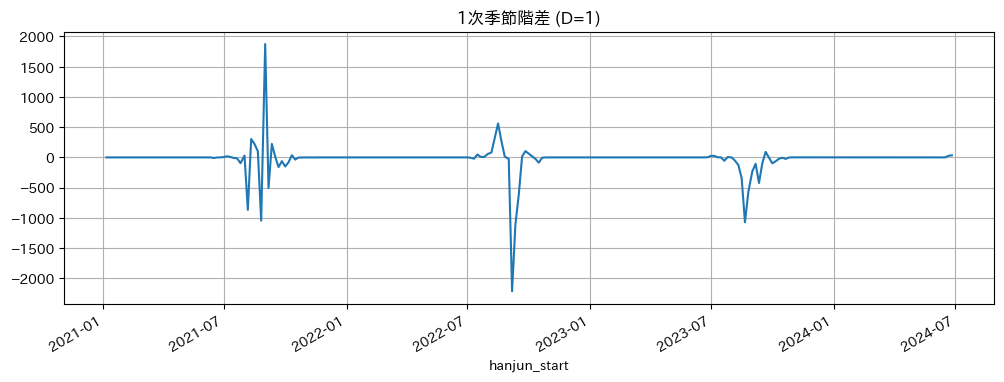

In [204]:
# 季節差分を適用してグラフを確認
train_y.diff(73).plot(figsize=(12,4), title='1次季節階差 (D=1)')
plt.grid()
plt.show()


### 非季節性パラメータ(p, q)の探索
次に、季節性の次数をシンプルな (0,1,0,73) に固定して、非季節性のパラメータ（p, d, q）だけのグリッドサーチを行います。これにより、計算が非常に高速になります。

In [205]:
# d=0, D=1 と仮定
d = 0
D = 1
s = 73

p = q = range(0, 3) # p,qの探索範囲を少し広げる
pdq = list(itertools.product(p, [d], q))

best_aic_pdq = np.inf
best_pdq = None

print("\n--- 非季節性の次数(p,d,q)を探索します ---")
for param in pdq:
    try:
        mod = sm.tsa.statespace.SARIMAX(train_y,
                                        exog=train_X,
                                        order=param,
                                        seasonal_order=(0, D, 0, s), # 季節性はシンプルに固定
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        results = mod.fit(disp=False)
        if results.aic < best_aic_pdq:
            best_aic_pdq = results.aic
            best_pdq = param
    except:
        continue

print(f'最も良い非季節性次数(p,d,q): {best_pdq} (AIC: {best_aic_pdq})')



--- 非季節性の次数(p,d,q)を探索します ---


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


最も良い非季節性次数(p,d,q): (0, 0, 2) (AIC: 3406.713285825811)


### 季節性パラメータ(P, Q)の探索
前ステップで見つけた最適な (p,d,q) を固定し、季節性パラメータ（P, D, Q）だけを探索します。

In [206]:
# 前ステップで見つけたbest_pdqは固定
P = Q = range(0, 2)
seasonal_pdq_only = [(x[0], D, x[1], s) for x in list(itertools.product(P, Q))]

best_aic_seasonal = np.inf
best_seasonal_pdq = None

print("\n--- 季節性の次数(P,D,Q)を探索します ---")
for param_seasonal in seasonal_pdq_only:
    try:
        mod = sm.tsa.statespace.SARIMAX(train_y,
                                        exog=train_X,
                                        order=best_pdq, # 前ステップの結果で固定
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        results = mod.fit(disp=False)
        if results.aic < best_aic_seasonal:
            best_aic_seasonal = results.aic
            best_seasonal_pdq = param_seasonal
    except:
        continue

print(f'最も良い季節性次数(P,D,Q,s): {best_seasonal_pdq} (AIC: {best_aic_seasonal})')

# 5~15分で完了



--- 季節性の次数(P,D,Q)を探索します ---


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


最も良い季節性次数(P,D,Q,s): (1, 1, 0, 73) (AIC: 2315.3264154166764)


### グリッドサーチの実行（スキップ）
ブルートフォースでは遅すぎるため，前述の段階的なパラメータの推定に変更した．

In [207]:
"""
# パラメータの探索範囲を定義
p = range(0, 2)
d = range(0, 2)
q = range(0, 2)
pdq = list(itertools.product(p, d, q)) # 2 * 2 * 2 = 8通りの組み合わせ
seasonal_pdq = [(x[0], x[1], x[2], 73) for x in list(itertools.product(
    range(0, 2),
    range(0, 2),
    range(0, 2)
    ))]

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None

print("\n--- 最適なSARIMAXパラメータを探索します（学習データを使用） ---")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_y,
                                            exog=train_X,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue

print(f'最も良いAIC: {best_aic}')
print(f'最も良い次数: order={best_pdq}, seasonal_order={best_seasonal_pdq}')
"""


'\n# パラメータの探索範囲を定義\np = range(0, 2)\nd = range(0, 2)\nq = range(0, 2)\npdq = list(itertools.product(p, d, q)) # 2 * 2 * 2 = 8通りの組み合わせ\nseasonal_pdq = [(x[0], x[1], x[2], 73) for x in list(itertools.product(\n    range(0, 2),\n    range(0, 2),\n    range(0, 2)\n    ))]\n\nbest_aic = np.inf\nbest_pdq = None\nbest_seasonal_pdq = None\n\nprint("\n--- 最適なSARIMAXパラメータを探索します（学習データを使用） ---")\nfor param in pdq:\n    for param_seasonal in seasonal_pdq:\n        try:\n            mod = sm.tsa.statespace.SARIMAX(train_y,\n                                            exog=train_X,\n                                            order=param,\n                                            seasonal_order=param_seasonal,\n                                            enforce_stationarity=False,\n                                            enforce_invertibility=False)\n            results = mod.fit(disp=False)\n            if results.aic < best_aic:\n                best_aic = results.aic\n                best_

# モデルの学習と診断
探索で見つけた最適な次数を使い、学習データで最終的なモデルを構築します。学習後、診断プロットでモデルの残差（誤差）が適切か（良いモデルの条件を満たしているか）を確認します。

## モデルの学習
- 係数coef：その説明変数が1単位増加したときに，目的変数がどれだけ増減するかを示す．絶対値が大きければ大きいほど，影響力が強い．符号は，正の相関か負の相関かを示す．
- p値：
    - 帰無仮説：「その説明変数は，目的変数に何の影響も与えない．（本当の係数は0である．）」
    - p値の意味：もし説明変数が本当は全く無関係だった場合に，今回得られたような関係性が偶然だけで観測されてしまう確率は (p * 100) % です，という意味．
    - 有意水準：0.05 (5%)とする．
    - p < 0.05 => 統計的に有意であり，帰無仮説を棄却する．無関係ではない．
    - p >= 0.05 => 統計的に有意ではなく，帰無仮説が棄却はされない．帰無仮説が正しいと言っているわけではない事に注意．

In [212]:
# 最適なパラメータでモデルを学習（数分）
model = sm.tsa.statespace.SARIMAX(train_y,
                                  exog=train_X,
                                  order=best_pdq,
                                  seasonal_order=best_seasonal_pdq,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results = model.fit(disp=False)

print("\n--- モデルのサマリー ---")
print(results.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



--- モデルのサマリー ---
                                      SARIMAX Results                                      
Dep. Variable:                          kill_score   No. Observations:                  324
Model:             SARIMAX(0, 0, 2)x(1, 1, [], 73)   Log Likelihood               -1151.663
Date:                             Fri, 19 Sep 2025   AIC                           2315.326
Time:                                     12:37:40   BIC                           2334.417
Sample:                                          0   HQIC                          2323.068
                                             - 324                                         
Covariance Type:                               opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
EVI_18半旬前         -17.0599     94.913     -0.180      0.857    -203.087     16

## モデルの保存

In [213]:
# ファイル名を指定（拡張子は .pkl が一般的）
dt_now = dt.datetime.now(pytz.timezone('Asia/Tokyo'))
model_path = "/content/drive/MyDrive/アストロキャンプ/models/sarimax_unka_model_" + dt_now.isoformat(timespec="seconds") + ".pkl"
results.save(model_path)

print(f"学習済みモデルを '{model_path}' に保存しました．")


学習済みモデルを '/content/drive/MyDrive/アストロキャンプ/models/sarimax_unka_model_2025-09-19T21:37:40+09:00.pkl' に保存しました．


## 診断プロット
診断プロットの見方: 右下の「Correlogram」（ACFプロット）で、ラグ1以降に青い領域からはみ出す自己相関がなければ、モデルが捉えきれなかった誤差はランダムであり、良いモデルであることを示唆します。
***
- 上のグラフ（残差の時系列プロット）:
理想は、0の線を中止に、特定のパターンなく、ランダムに値が散らばっていることです。もし周期的な波や、時間と共にばらつきが広がるなどの傾向が見られたら、モデルが捉えきれていない情報が残っているサインです。

- 下のグラフ（残差の自己相関プロット）:
理想は、ラグ0（自分自身との相関なので常に1）以外に、青い信頼区間を大きくはみ出す棒がないことです。もしはみ出す棒があれば、それは誤差同士にまだ相関が残っている（＝モデルが予測に使える情報を残している）ことを意味します。

--- モデルの読み込みに成功しました ---
                                      SARIMAX Results                                      
Dep. Variable:                          kill_score   No. Observations:                  324
Model:             SARIMAX(0, 0, 2)x(1, 1, [], 73)   Log Likelihood               -1151.663
Date:                             Fri, 19 Sep 2025   AIC                           2315.326
Time:                                     12:37:55   BIC                           2334.417
Sample:                                          0   HQIC                          2323.068
                                             - 324                                         
Covariance Type:                               opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
EVI_18半旬前         -17.0599     94.913     -0.180      0.857    -203.087 

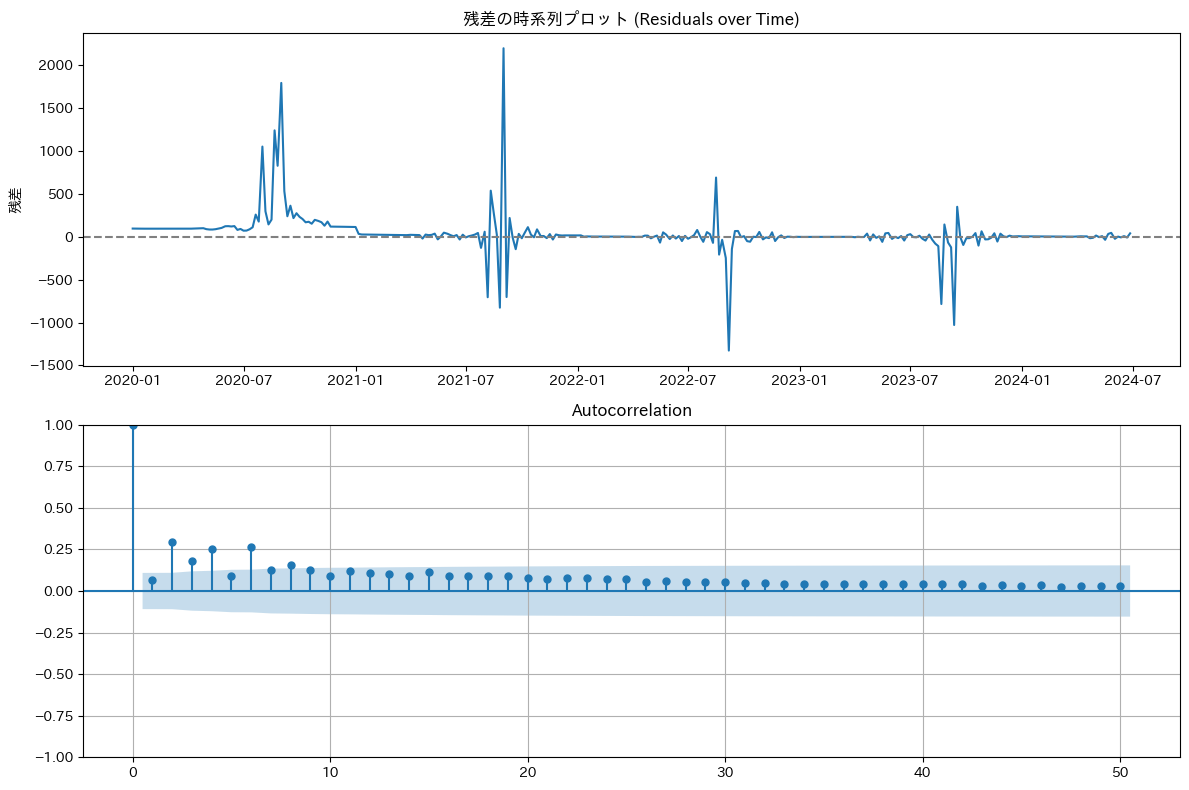

In [214]:
# model_path = "/content/drive/MyDrive/アストロキャンプ/models/sarimax_unka_model_2025-09-19T06:26:02+09:00.pkl"

# statsmodelsの専用関数でモデルをロード
try:
    loaded_results = sm.load(model_path)
    print("--- モデルの読み込みに成功しました ---")
    print(loaded_results.summary())

    # --- 診断プロットの表示（ラグ数を減らしてエラーを回避） ---
    # lagsパラメータを追加して、診断プロットが参照するラグの数を制限
    # 季節周期(73)未満の50などに設定
    print("\n--- 診断プロットを生成します ---")

    # 自動診断ツールはデータ数が少ないため使えない模様
    """
    fig = loaded_results.plot_diagnostics(figsize=(15, 12), lags=50)
    plt.tight_layout()
    plt.show()
    """

    # --- 手動で診断プロットを作成 ---

    # 1. モデルから残差（= 実測値 - 予測値）を抽出
    residuals = loaded_results.resid

    # 描画エリアを準備
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))

    # 2. プロット1：残差の時系列プロット
    axes[0].plot(residuals)
    axes[0].axhline(0, linestyle='--', color='gray')
    axes[0].set_title('残差の時系列プロット (Residuals over Time)')
    axes[0].set_ylabel('残差')

    # 3. プロット2：残差の自己相関（ACF）プロット
    sm.graphics.tsa.plot_acf(residuals, lags=50, ax=axes[1])

    plt.tight_layout()
    plt.grid()
    plt.show()

except FileNotFoundError:
    print(f"エラー: ファイル '{model_path}' が見つかりません。")
except Exception as e:
    print(f"モデルの読み込みまたはプロット中にエラーが発生しました: {e}")


# 予測と評価

## 未来予測の実行
loadで読み込んだモデルオブジェクト（loaded_results）を使い、テストデータ期間（例：2024年）の値を予測します。この際、その期間に対応する説明変数（test_X）も渡す必要があります。



In [215]:
# --- 予測の実行 ---
# test_y と test_X は、事前に分割しておいた2024年のデータ

# 予測する期間のステップ数を計算（例：2024年の活動期間のデータ数）
forecast_steps = len(test_y)

# .get_forecast() を使って未来予測を生成
# stepsに予測したい期間の長さを、exogにその期間の説明変数を渡す
forecast = loaded_results.get_forecast(steps=forecast_steps, exog=test_X)

# 予測結果の平均値を取得
y_forecasted = forecast.predicted_mean.to_frame()
y_forecasted = y_forecasted.clip(lower=0) # 負の値は0へ置き換え
y_forecasted.set_index(test_X.index, inplace=True)

# 予測の信頼区間を取得
pred_ci = forecast.conf_int()
pred_ci.set_index(test_X.index, inplace=True)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


## 結果の可視化と精度評価
最後に、予測値と実測値をグラフに重ねてプロットし、視覚的に精度を確認します。また、RMSE（Root Mean Squared Error）のような評価指標を計算し、予測誤差の平均的な大きさを定量的に評価します。

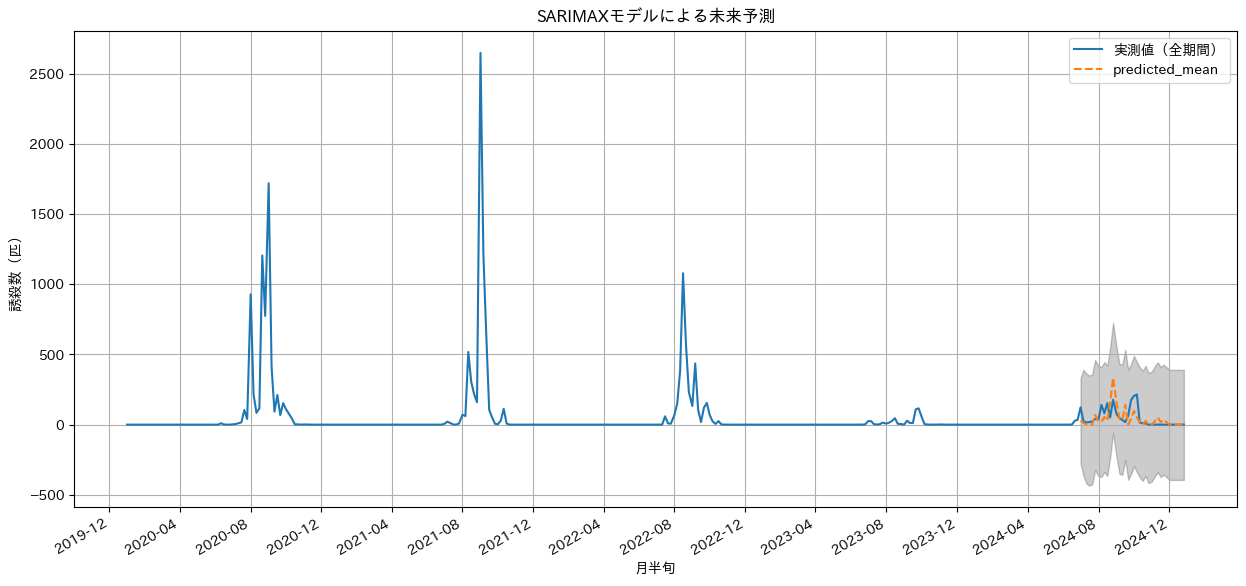


2024年活動期間におけるRMSE: 68.09


In [216]:
# --- 予測結果の可視化 ---
plt.figure(figsize=(15, 7))
ax = y.plot(label='実測値（全期間）') # 比較のため全期間の実測値をプロット
y_forecasted.plot(ax=ax, label='未来予測値 (2024年)', style='--')

# 月ごとに目盛りを表示
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))  # 4ヶ月ごと
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))  # YYYY-MM 表記

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.title('SARIMAXモデルによる未来予測')
plt.xlabel("月半旬")
plt.ylabel("誘殺数（匹）")
plt.legend()
plt.grid()
plt.show()

# --- 精度の定量評価 ---
# 予測期間の実測値と予測値でRMSEを計算
rmse = np.sqrt(mean_squared_error(test_y, y_forecasted))
print(f'\n2024年活動期間におけるRMSE: {rmse:.2f}')


## 多重共線性の排除

### 分散拡大要因VIF


1. 係数（coef）が不安定になる：
モデルが「どの変数がどれだけ影響しているのか」を正確に分離できなくなります。例えば、「1期前の積算温度」と「2期前の積算温度」は非常に似た値を取るため、モデルはどちらの功績かを判断できず、係数が極端に大きくなったり、符号が予期せず反転したりします。

2. 係数の解釈が困難になる：
上記の理由から、係数の値を「その変数が与える純粋な影響」として信頼できなくなります。

3. p値が大きくなる（有意になりにくくなる）：
係数の推定が不安定になるため、標準誤差が大きくなります。その結果、p値が大きくなり、本当は効果があるはずの変数が「統計的に有意ではない（p > 0.05）」という誤った結論に至る可能性があります。
***
- 分散拡大要因VIF：慣例的にVIFが10を超えると、多重共線性の問題が強いと判断されます。

もしVIFが高い変数が見つかった場合は、以下のいずれかの対処法をとるのが一般的です。

1. 変数の一方を選択して削除する（最も簡単）：
相関が高い変数ペアのうち、どちらか一方をモデルから除外します。どちらを削除するかは、モデルのサマリーを見てp値がより大きい方（より効いていない方）を選ぶのが合理的です。

2. 変数を結合して新しい特徴量を作成する：
例えば、「1期前から3期前の積算温度の平均値」という新しい変数を1つだけ作り、元の3つの変数の代わりに使う。

例えば、VIFが30というのは、その説明変数の持つ情報の約97%（計算式: 1 - 1/30）が、他の説明変数によって説明できてしまう、ということを意味します。つまり、その変数はほぼ完全に他の変数と重複しており、モデルにとって新しい情報をほとんど提供できていない状態です。

In [217]:
# 学習データの説明変数（train_X）を使ってVIFを計算
# train_X は pandas の DataFrame とします

# VIFを計算するための準備（定数項を追加）
X_with_const = sm.add_constant(train_X)

# 各変数に対してVIFを計算
vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

print("--- VIF（分散拡大要因）---")
# 定数項(const)のVIFは無視します
print(vif_data.iloc[1:])


--- VIF（分散拡大要因）---
           feature       VIF
1        EVI_18半旬前  1.268045
2  EVI_1半旬微分_22半旬前  1.268045


### 相関マトリクスでの単純相関

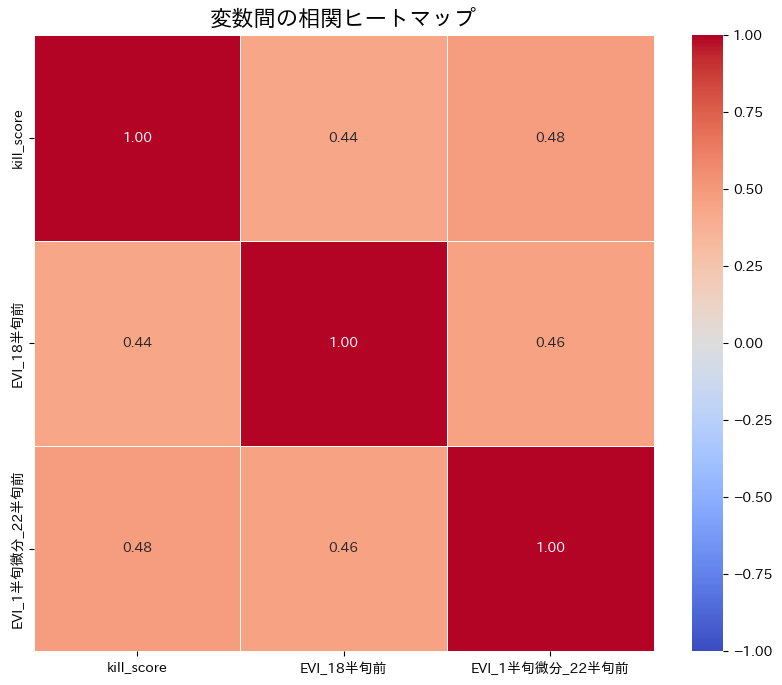

In [218]:
plt.figure(figsize=(10, 8))

# seabornのheatmap関数を呼び出す
sns.heatmap(
    df.corr(),         # データとして相関行列を渡す
    annot=True,        # セル内に数値を表示する
    cmap='coolwarm',   # 色のマップを指定（正の相関は暖色、負の相関は寒色）
    fmt='.2f',         # 数値の書式（小数点以下2桁）
    linewidths=.5,     # セル間の線の太さ
    vmin=-1,
    vmax=1
)

plt.title('変数間の相関ヒートマップ', fontsize=16)
plt.show()


## 説明変数 vs 目的変数の散布図

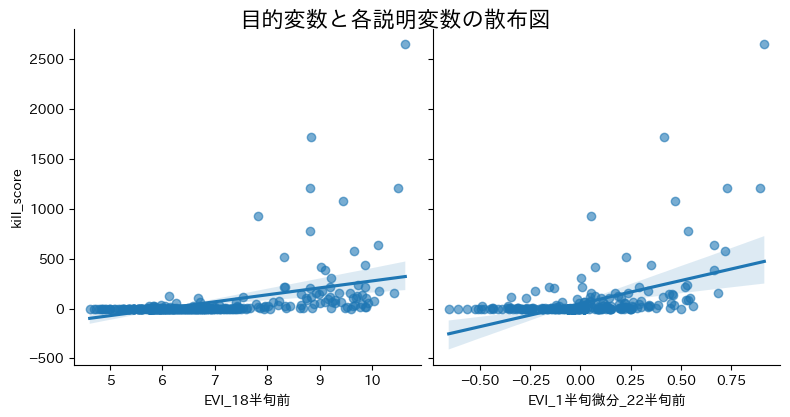

In [219]:
# 説明変数と目的変数の列名を定義
target_variable = 'kill_score'
predictor_variables = list(X.columns)

# pairplotで散布図と回帰直線を同時に描画
# x_varsに説明変数、y_varsに目的変数を指定
sns.pairplot(
    df,
    x_vars=predictor_variables,
    y_vars=[target_variable],
    kind='reg',  # 'reg'を指定すると回帰直線が引かれる
    height=4,    # 各グラフのサイズ
    plot_kws={'scatter_kws': {'alpha': 0.6}} # 点を半透明にする
)

plt.suptitle('目的変数と各説明変数の散布図', y=1.02, size=16)
plt.show()
